In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only'


#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-0.5k-perfect'

#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-0.5k-mediumbad'





#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-5k-perfect'

#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-50k-goodres'

input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-5k-nominal-resolution'

#input_dir = 'hist-pdf-toy-study-1d-2a-save-hist-only-5k-mediumbad'





off_diag_clip_delta_bins = 100
off_diag_damping_rate = 1.0


#-- 1 seems to work well for mediumbad.  2 may be good as well.
####diagonal_constant = 1.

diagonal_constant = 1.0


#fitType = 'bin center approximation'
fitType = 'integral within bin'




#rcond_val = 0.


#-- the magic number.  Ok for goodres 50k
rcond_val = 0.001


#-- improves for mediumbad 5k and perfect 5k, NFG for nominal, bit biased for goodres,
#rcond_val = 0.0002



#-- biased for goodres 50k
#rcond_val = 0.00032

#-- very biased for goodres 50k
#rcond_val = 0.0015

#-- very biased for goodres 50k
#rcond_val = 0.00005


In [3]:
with open( '%s/bootstrap-output-histograms.npy' % input_dir, 'rb') as f :
    boot_hist_content = np.load(f, allow_pickle=True )
    hist_bin_edges = np.load(f, allow_pickle=True)

In [4]:
hist_nbins = len(hist_bin_edges) - 1
hist_xlow = hist_bin_edges[0]
hist_xhigh = hist_bin_edges[-1]
print('\n\n  hist_nbins = %d,  range %.2f to %.2f\n\n' % (hist_nbins, hist_xlow, hist_xhigh))



  hist_nbins = 20,  range -3.00 to 3.00




In [5]:
hist_bin_edges

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])

In [6]:
hist_bin_centers = np.zeros( hist_nbins )
for bi in range(hist_nbins) :
    hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])

In [7]:
hist_bin_centers

array([-2.85, -2.55, -2.25, -1.95, -1.65, -1.35, -1.05, -0.75, -0.45,
       -0.15,  0.15,  0.45,  0.75,  1.05,  1.35,  1.65,  1.95,  2.25,
        2.55,  2.85])

In [8]:
bin_width = hist_bin_edges[1] - hist_bin_edges[0]

In [9]:
boot_hist_content.shape

(5000, 20)

In [10]:
n_samples = len(boot_hist_content)
print('\n\n Have %d samples\n\n' % n_samples)



 Have 5000 samples




In [11]:
boot_hist_content

array([[  4.412735  ,  12.11544754,  34.27210016, ..., 103.26210978,
         45.03312245,  19.8948256 ],
       [  2.88433215,   9.60822099,  32.99865762, ..., 118.48466423,
         53.66921985,  20.35647372],
       [  4.89960014,  15.04072333,  42.03704384, ..., 112.82250967,
         49.89414847,  19.92362046],
       ...,
       [  6.18508983,  14.58111802,  36.39456558, ..., 100.96057399,
         42.6976351 ,  17.26151954],
       [  6.18213016,  16.4882954 ,  40.46000657, ..., 103.16637107,
         45.89117566,  19.50658297],
       [  4.29652073,  13.00920992,  38.35371158, ..., 113.12191705,
         44.4370844 ,  13.6433459 ]])

In [12]:
boot_hist_content[:,6]

array([524.42269806, 501.99950615, 514.19167861, ..., 504.17491546,
       477.42864162, 489.84055656])

In [13]:
off_diag_damping_factor = np.ones( shape=(hist_nbins) )
for bi in range( 1, hist_nbins ) :
    off_diag_damping_factor[bi] = off_diag_damping_factor[bi-1] * off_diag_damping_rate
    print(' %3d : %.3f' % (bi, off_diag_damping_factor[bi]))

   1 : 1.000
   2 : 1.000
   3 : 1.000
   4 : 1.000
   5 : 1.000
   6 : 1.000
   7 : 1.000
   8 : 1.000
   9 : 1.000
  10 : 1.000
  11 : 1.000
  12 : 1.000
  13 : 1.000
  14 : 1.000
  15 : 1.000
  16 : 1.000
  17 : 1.000
  18 : 1.000
  19 : 1.000


In [14]:
hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        delta_index = int( np.absolute(bi-bj) )
        
        
        if delta_index < off_diag_clip_delta_bins :
            
            hist_corr_mat[bi,bj] = ccm[0,1] * off_diag_damping_factor[delta_index]

            hist_cov_mat[bi,bj] = cvm[0,1] * off_diag_damping_factor[delta_index]
            
            if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [15]:
hist_corr_mat[0,hist_nbins-1] = -1.

<function matplotlib.pyplot.show(close=None, block=None)>

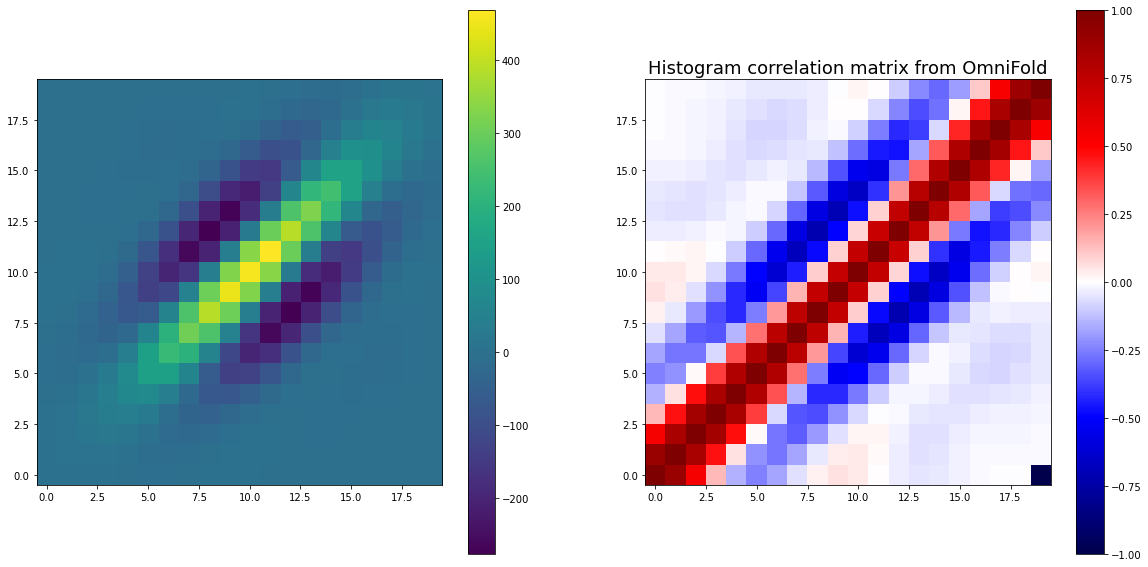

In [16]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [17]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -275.87 , 468.06




<function matplotlib.pyplot.show(close=None, block=None)>

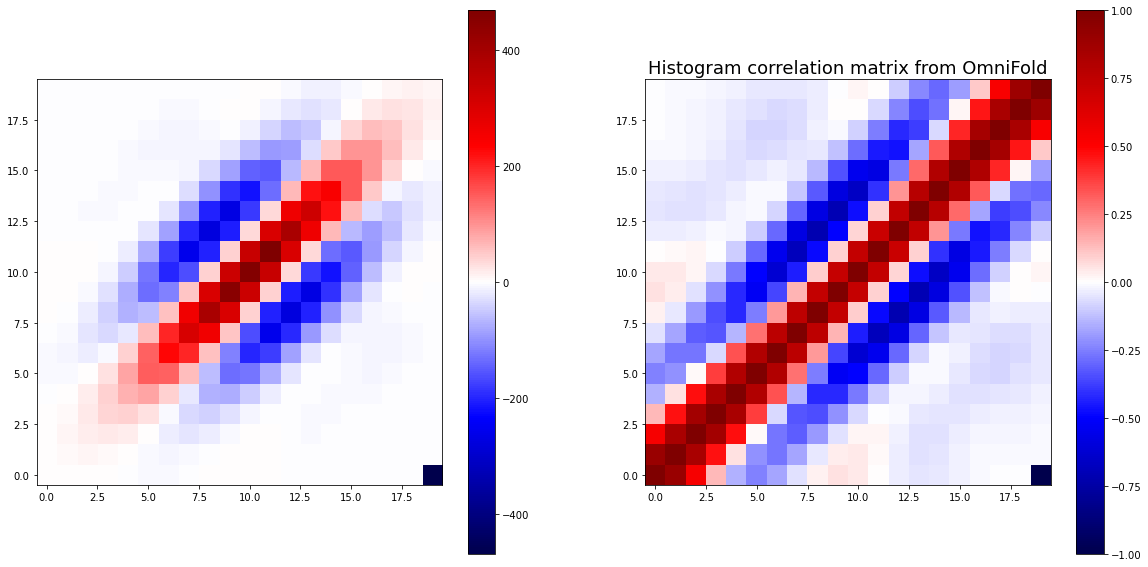

In [18]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [19]:
for bi in range(hist_nbins) :
    for bj in range(hist_nbins ) :
        
        calc_corr = hist_cov_mat[bi,bj] / np.sqrt( hist_cov_mat[bi,bi] * hist_cov_mat[bj,bj])
        
        print('  %2d, %2d :  histi  %10.2f   histj %10.2f  cov = %9.3f   cor = %9.4f  (%9.4f)' % 
              (bi, bj, boot_hist_content[0,bi], boot_hist_content[0,bj],
               hist_cov_mat[bi,bj], hist_corr_mat[bi,bj], calc_corr))



   0,  0 :  histi        4.41   histj       4.41  cov =     3.086   cor =    1.0000  (   1.0000)
   0,  1 :  histi        4.41   histj      12.12  cov =     3.078   cor =    0.8944  (   0.6781)
   0,  2 :  histi        4.41   histj      34.27  cov =     3.093   cor =    0.5280  (   0.4215)
   0,  3 :  histi        4.41   histj      77.23  cov =     1.216   cor =    0.1383  (   0.1122)
   0,  4 :  histi        4.41   histj     160.45  cov =    -1.814   cor =   -0.1494  (  -0.1220)
   0,  5 :  histi        4.41   histj     318.97  cov =    -4.251   cor =   -0.2437  (  -0.1997)
   0,  6 :  histi        4.41   histj     524.42  cov =    -3.856   cor =   -0.1771  (  -0.1453)
   0,  7 :  histi        4.41   histj     781.84  cov =    -1.564   cor =   -0.0619  (  -0.0508)
   0,  8 :  histi        4.41   histj    1045.92  cov =     0.734   cor =    0.0258  (   0.0212)
   0,  9 :  histi        4.41   histj    1242.13  cov =     1.708   cor =    0.0560  (   0.0460)
   0, 10 :  histi        4.41 

In [20]:
print('      ', end='')
for bj in range( hist_nbins ) :
    print('   %2d   ' % bj, end='')
print()

for bi in range( hist_nbins ) :
    print(' %2d : ' % bi, end='')
    for bj in range( hist_nbins ) :
        print( ' %6.3f ' % hist_corr_mat[bi,bj], end='')
    print()

          0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
  0 :   1.000   0.894   0.528   0.138  -0.149  -0.244  -0.177  -0.062   0.026   0.056   0.042   0.005  -0.034  -0.051  -0.044  -0.027  -0.012  -0.006  -0.005  -1.000 
  1 :   0.894   1.000   0.830   0.466   0.059  -0.214  -0.268  -0.173  -0.043   0.036   0.047   0.010  -0.039  -0.059  -0.049  -0.029  -0.013  -0.009  -0.010  -0.010 
  2 :   0.528   0.830   1.000   0.857   0.470   0.013  -0.271  -0.313  -0.196  -0.056   0.020   0.017  -0.029  -0.058  -0.055  -0.037  -0.021  -0.016  -0.016  -0.013 
  3 :   0.138   0.466   0.857   1.000   0.830   0.382  -0.073  -0.334  -0.349  -0.216  -0.072  -0.005  -0.014  -0.043  -0.054  -0.048  -0.036  -0.029  -0.024  -0.018 
  4 :  -0.149   0.059   0.470   0.830   1.000   0.803   0.342  -0.146  -0.421  -0.421  -0.260  -0.099  -0.022  -0.017  -0.038  -0.055  -0.058  -0.054  -0.042  -0.030

In [21]:
cov_det = np.linalg.det( hist_cov_mat )
print('\n\n Histogram covariance matrix determinant:  %9.4f\n\n' % cov_det)



 Histogram covariance matrix determinant:  19821472341739597824.0000




In [22]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
print(hist_cov_inv)

[[ 0.70114337 -0.25438047 -0.04485313  0.09658135  0.06597555  0.01386473
   0.02338575  0.04738648  0.03313844  0.02782665  0.03557144  0.03525649
   0.0341781   0.03179793  0.03527072  0.04125513  0.03357316  0.02729961
   0.04002645  0.07803392]
 [-0.25438047  0.65994406 -0.23949847  0.00346909  0.11705791  0.05170485
  -0.00409281  0.04756192  0.05147472  0.02651532  0.03237628  0.04437601
   0.03852656  0.03104103  0.0398576   0.046613    0.03579837  0.02935926
   0.04494394  0.08652232]
 [-0.04485313 -0.23949847  0.58033135 -0.27223749  0.02346951  0.1106559
   0.0156033   0.00783327  0.04941437  0.03741269  0.0196816   0.036404
   0.03827625  0.02709423  0.03223266  0.04075514  0.03300944  0.02576212
   0.03851685  0.07545075]
 [ 0.09658135  0.00346909 -0.27223749  0.52293321 -0.2766177   0.05834463
   0.09731366 -0.00632205  0.01243633  0.04998183  0.02582085  0.01812367
   0.03314479  0.03137084  0.02407286  0.03190619  0.03084864  0.02386838
   0.03147183  0.06118129]
 [ 0.06

In [23]:
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )
print( cov_inv_test)

[[ 1.00000000e+00  1.45029809e-16 -3.30150145e-16 -2.57449618e-16
  -3.77789403e-15  8.32856792e-15 -1.56275920e-15 -3.89799664e-15
   2.10735869e-15  8.43084209e-15 -1.14104000e-14 -6.16739609e-16
   2.51778231e-16 -8.09386934e-16  1.76643544e-15  2.49840840e-17
   1.15214054e-15 -3.37308167e-16 -1.34907703e-16  1.32747565e-15]
 [ 4.51464134e-16  1.00000000e+00 -1.42176090e-15  6.24050762e-15
  -2.64240306e-15 -5.19912331e-15  2.15668842e-15  9.64886250e-15
   3.80011867e-15  5.28452870e-15 -5.19074244e-15 -5.62708750e-15
   1.44982709e-15 -1.65222345e-15  7.39816031e-16 -1.58145985e-15
  -6.90334313e-16  2.42101681e-16 -1.22553655e-15 -3.97028263e-16]
 [ 5.96976614e-16 -9.73859358e-17  1.00000000e+00  7.00988294e-15
  -5.66810129e-15  2.17196431e-15 -6.64905924e-17  3.83682106e-15
   2.69900953e-15  8.73483477e-15 -1.99384444e-15 -2.15542505e-15
   1.05728465e-15  2.38000194e-16 -5.00514970e-16 -1.06923625e-15
   1.24221940e-15  2.89146873e-16 -6.40439605e-16 -5.33303489e-16]
 [ 1.14

<function matplotlib.pyplot.show(close=None, block=None)>

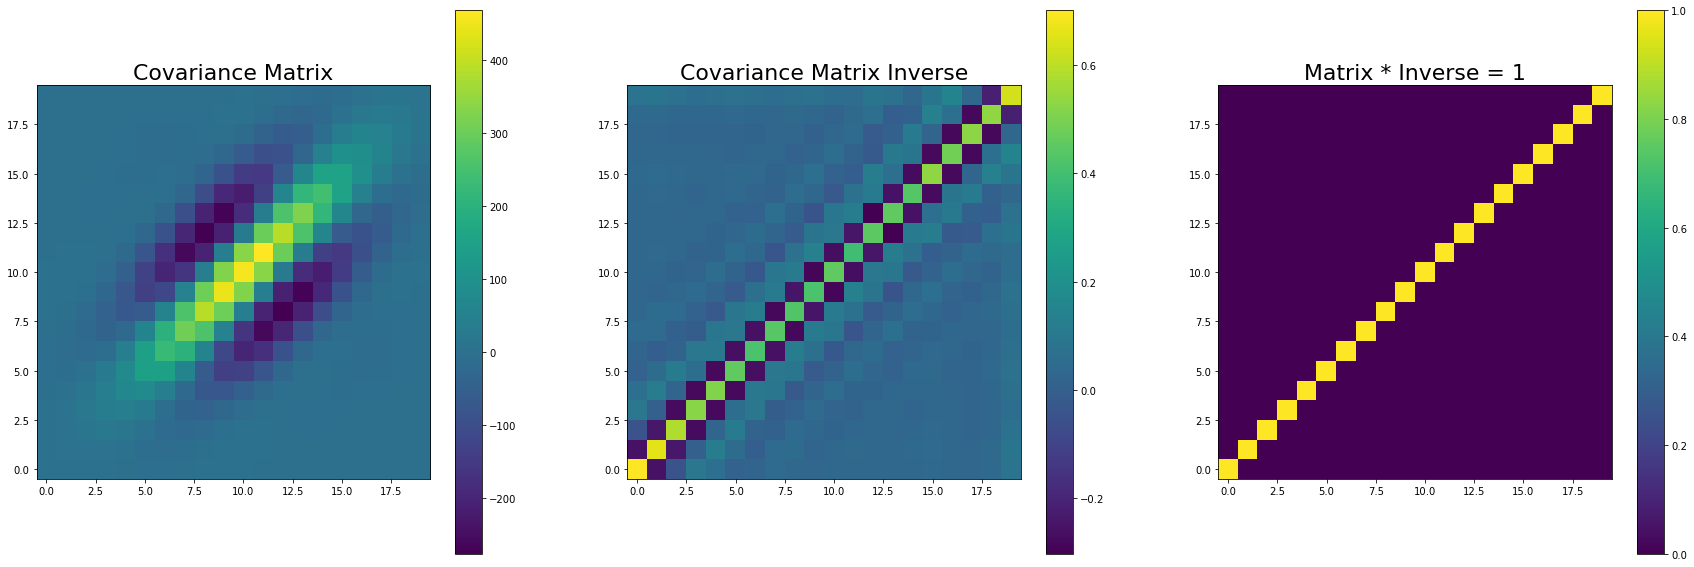

In [24]:
fig,ax = plt.subplots( 1, 3, figsize=(3*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im_covinv = ax[1].imshow(hist_cov_inv, origin='lower')
ax[1].figure.colorbar( im_covinv, ax=ax[1] )

im_covtest = ax[2].imshow(cov_inv_test, origin='lower')
ax[2].figure.colorbar( im_covtest, ax=ax[2] )

ax[0].set_title('Covariance Matrix', fontsize='22')
ax[1].set_title('Covariance Matrix Inverse', fontsize='22')
ax[2].set_title('Matrix * Inverse = 1', fontsize='22')

plt.show



In [25]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max




 min and max of covariance matrix inverse:  -0.30  0.70




<function matplotlib.pyplot.show(close=None, block=None)>

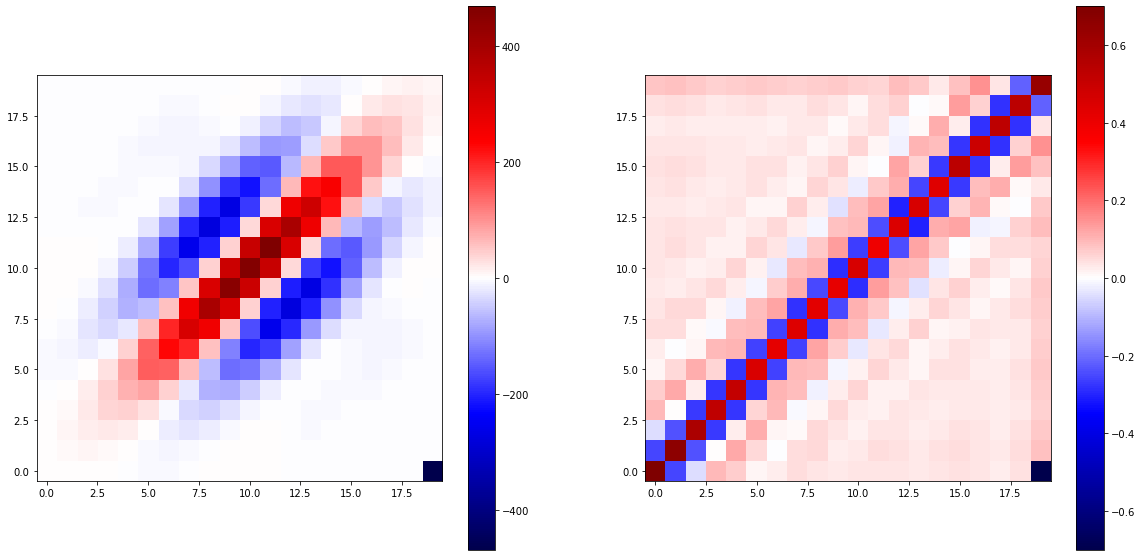

In [26]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

(-50.0, 50.0)

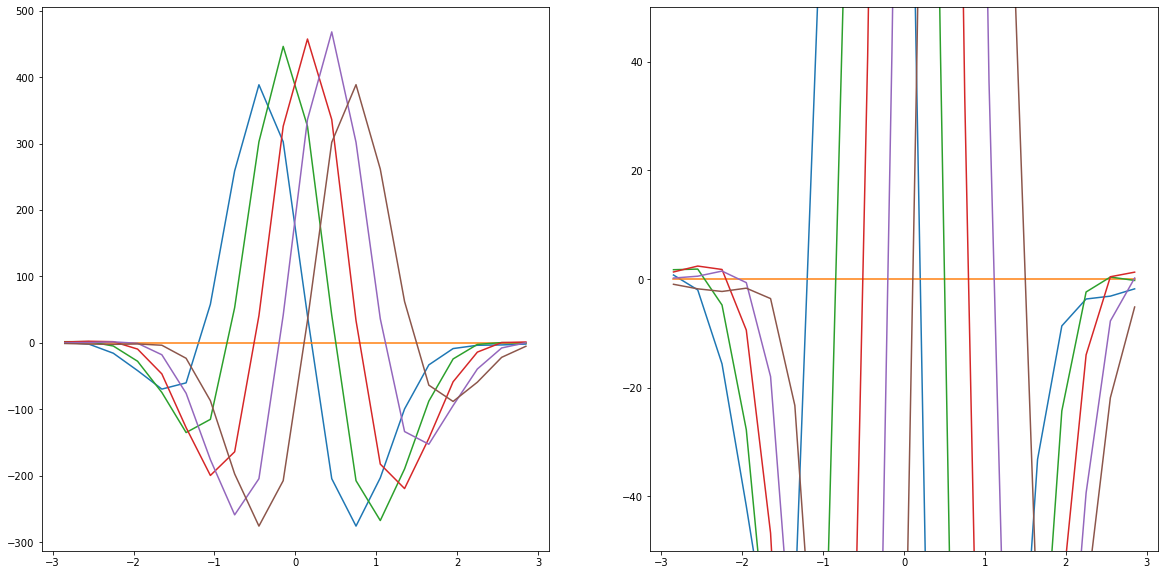

In [27]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[0].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[12,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[1].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[12,:] )


ax[1].set_ylim([-50,50])

(-50.0, 50.0)

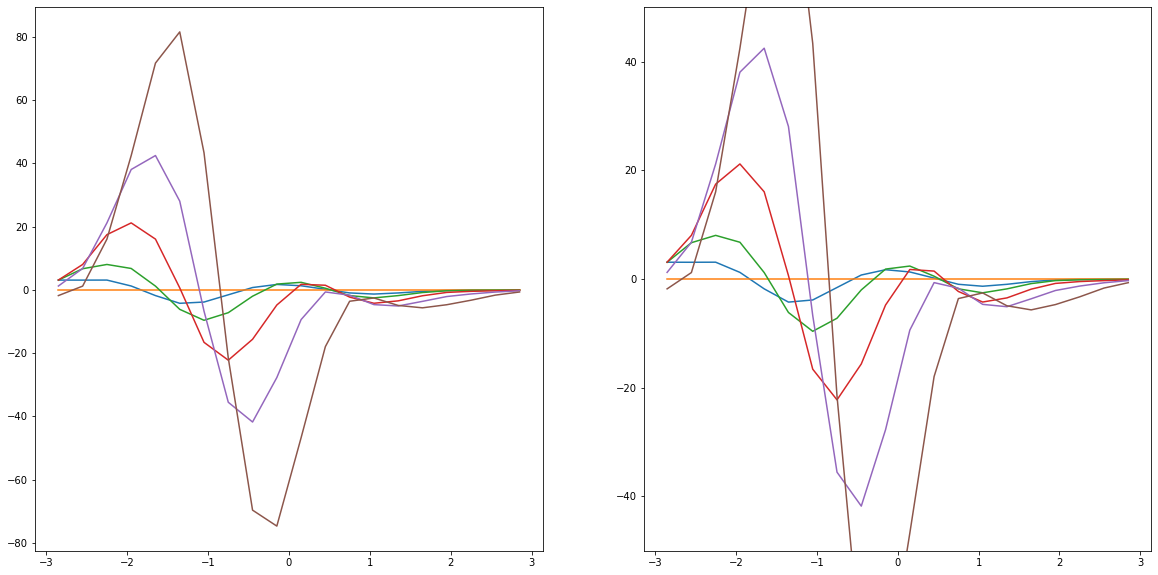

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[4,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[4,:] )


ax[1].set_ylim([-50,50])

## Try using the pseudo inverse of the covariance matrix for the chi2

In [29]:

#--- off
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat )


#--- not enough?
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.0001 )

#--- ok
##########hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.001 )
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.01 )

#-- probably too much
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.05 )


hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )



print(hist_cov_pinv)

[[ 1.65751004e-01  1.05154597e-01 -4.84826917e-02 -8.58362192e-02
   5.82322064e-02  6.93621488e-02 -6.97689578e-02 -2.80440917e-03
   6.76106906e-02 -3.42244295e-02 -2.03510151e-02  5.68860524e-02
  -2.01142755e-02 -2.27382215e-02  5.15458008e-02 -4.65890032e-03
  -3.82195913e-02  3.52544498e-02  5.10439415e-02 -7.40772991e-02]
 [ 1.05154597e-01  8.09482355e-02 -5.36064275e-03 -4.41447086e-02
   2.15042439e-02  4.06023586e-02 -2.09860461e-02 -9.45200471e-04
   2.93447969e-02 -7.94439900e-03 -1.52098244e-04  2.43549861e-02
  -9.85640171e-03  2.19578367e-03  3.13870089e-02 -1.08849714e-02
  -1.71164408e-02  3.82577892e-02  3.43791225e-02 -6.34802509e-02]
 [-4.84826917e-02 -5.36064275e-03  6.35506052e-02  5.42817455e-02
  -3.48357768e-02 -2.74854458e-02  6.11842430e-02  1.52963097e-02
  -3.81024157e-02  2.94649812e-02  3.67425400e-02 -2.55043926e-02
   6.49657060e-03  3.83058524e-02 -1.78120102e-03 -1.19162820e-02
   1.85083788e-02  2.97405687e-02  4.16168851e-03 -1.67233056e-02]
 [-8.58

In [30]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv

In [31]:
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

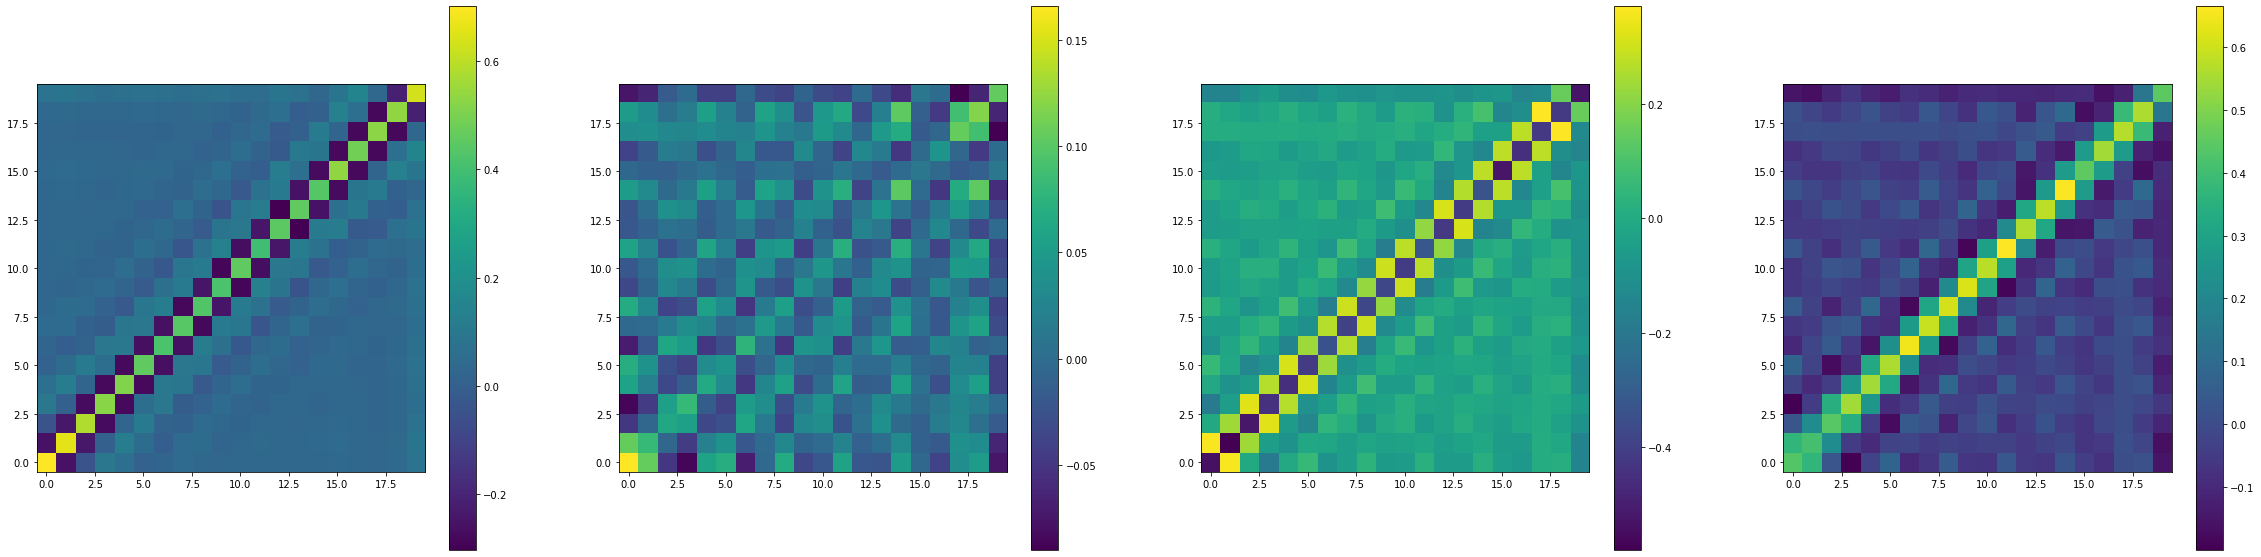

In [32]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [33]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.09  0.17




<function matplotlib.pyplot.show(close=None, block=None)>

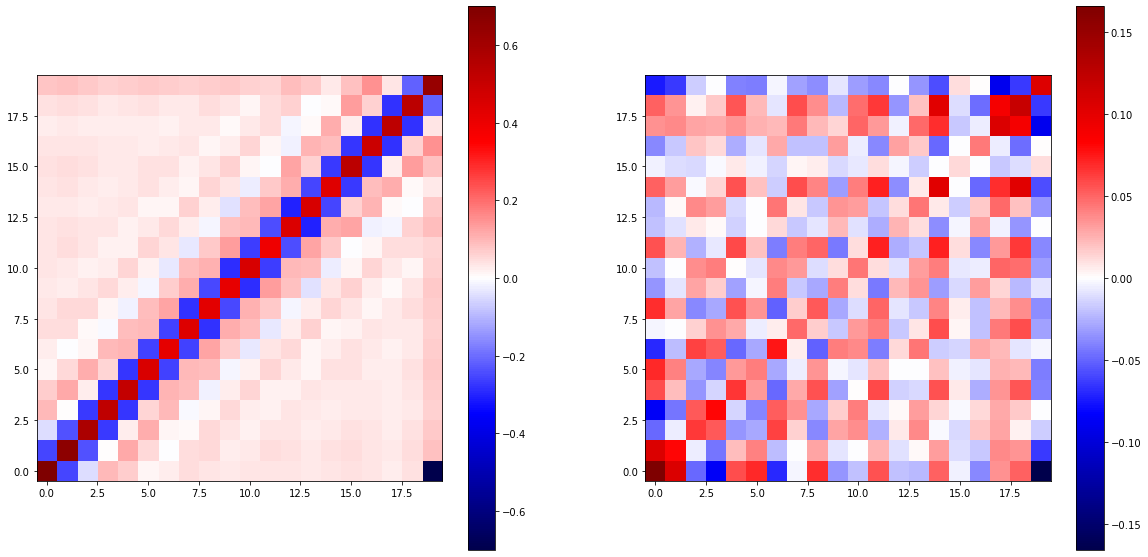

In [34]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [35]:
hist_inverse_of_pinv = np.linalg.inv( hist_cov_pinv )

<function matplotlib.pyplot.show(close=None, block=None)>

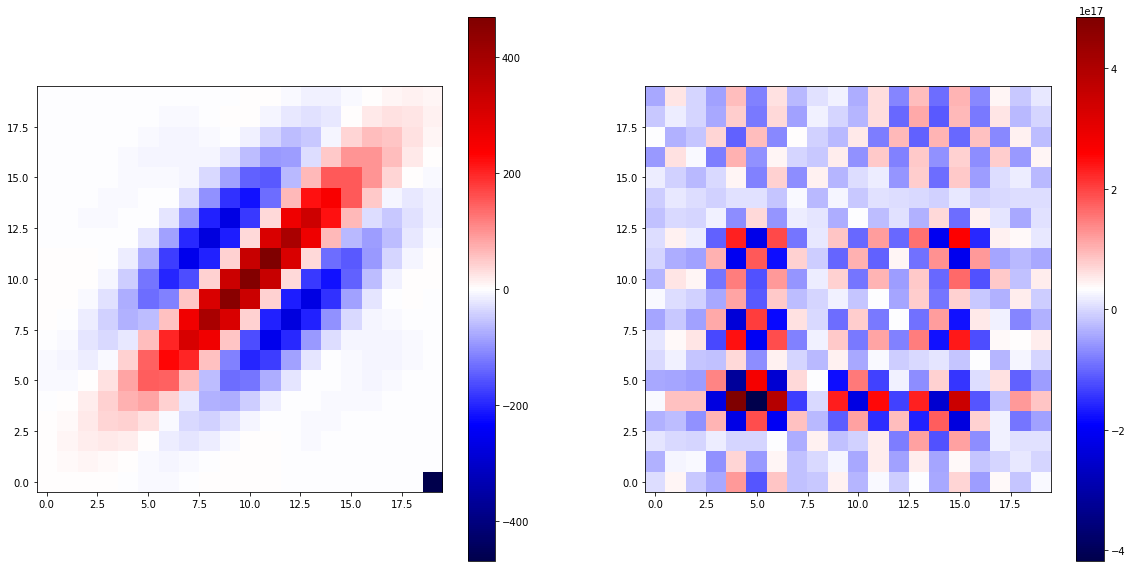

In [36]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_inverse_of_pinv, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [37]:
cov_mat_evals = np.linalg.eigvals( hist_cov_mat )

In [38]:
for evi in range( len(cov_mat_evals) ) :
    evratio = cov_mat_evals[evi]/cov_mat_evals[0]
    print(' %3d : %12.5f  %.7f' % (evi, cov_mat_evals[evi], evratio), end='')
    if evratio < 0.001 : print(' * ', end='')
    print()

   0 :   1446.12005  1.0000000
   1 :   1389.84590  0.9610861
   2 :    456.97165  0.3159984
   3 :    335.11401  0.2317332
   4 :    117.02345  0.0809224
   5 :     66.74204  0.0461525
   6 :     23.73653  0.0164139
   7 :     12.71211  0.0087905
   8 :      4.68776  0.0032416
   9 :      2.50633  0.0017331
  10 :      1.59356  0.0011020
  11 :      1.22956  0.0008502 * 
  12 :      1.08210  0.0007483 * 
  13 :      1.04461  0.0007224 * 
  14 :      1.02827  0.0007111 * 
  15 :      1.00936  0.0006980 * 
  16 :      1.00032  0.0006917 * 
  17 :      1.00142  0.0006925 * 
  18 :      1.00588  0.0006956 * 
  19 :      1.00409  0.0006943 * 


In [39]:
U, S, Vh = np.linalg.svd( hist_cov_mat, full_matrices=True)

In [40]:
S

array([1.44612005e+03, 1.38984590e+03, 4.56971652e+02, 3.35114009e+02,
       1.17023452e+02, 6.67420379e+01, 2.37365309e+01, 1.27121063e+01,
       4.68775876e+00, 2.50633032e+00, 1.59356415e+00, 1.22956114e+00,
       1.08209927e+00, 1.04461450e+00, 1.02827425e+00, 1.00935716e+00,
       1.00588023e+00, 1.00408976e+00, 1.00142430e+00, 1.00031959e+00])



 N rows = 4, N cols = 5


<function matplotlib.pyplot.show(close=None, block=None)>

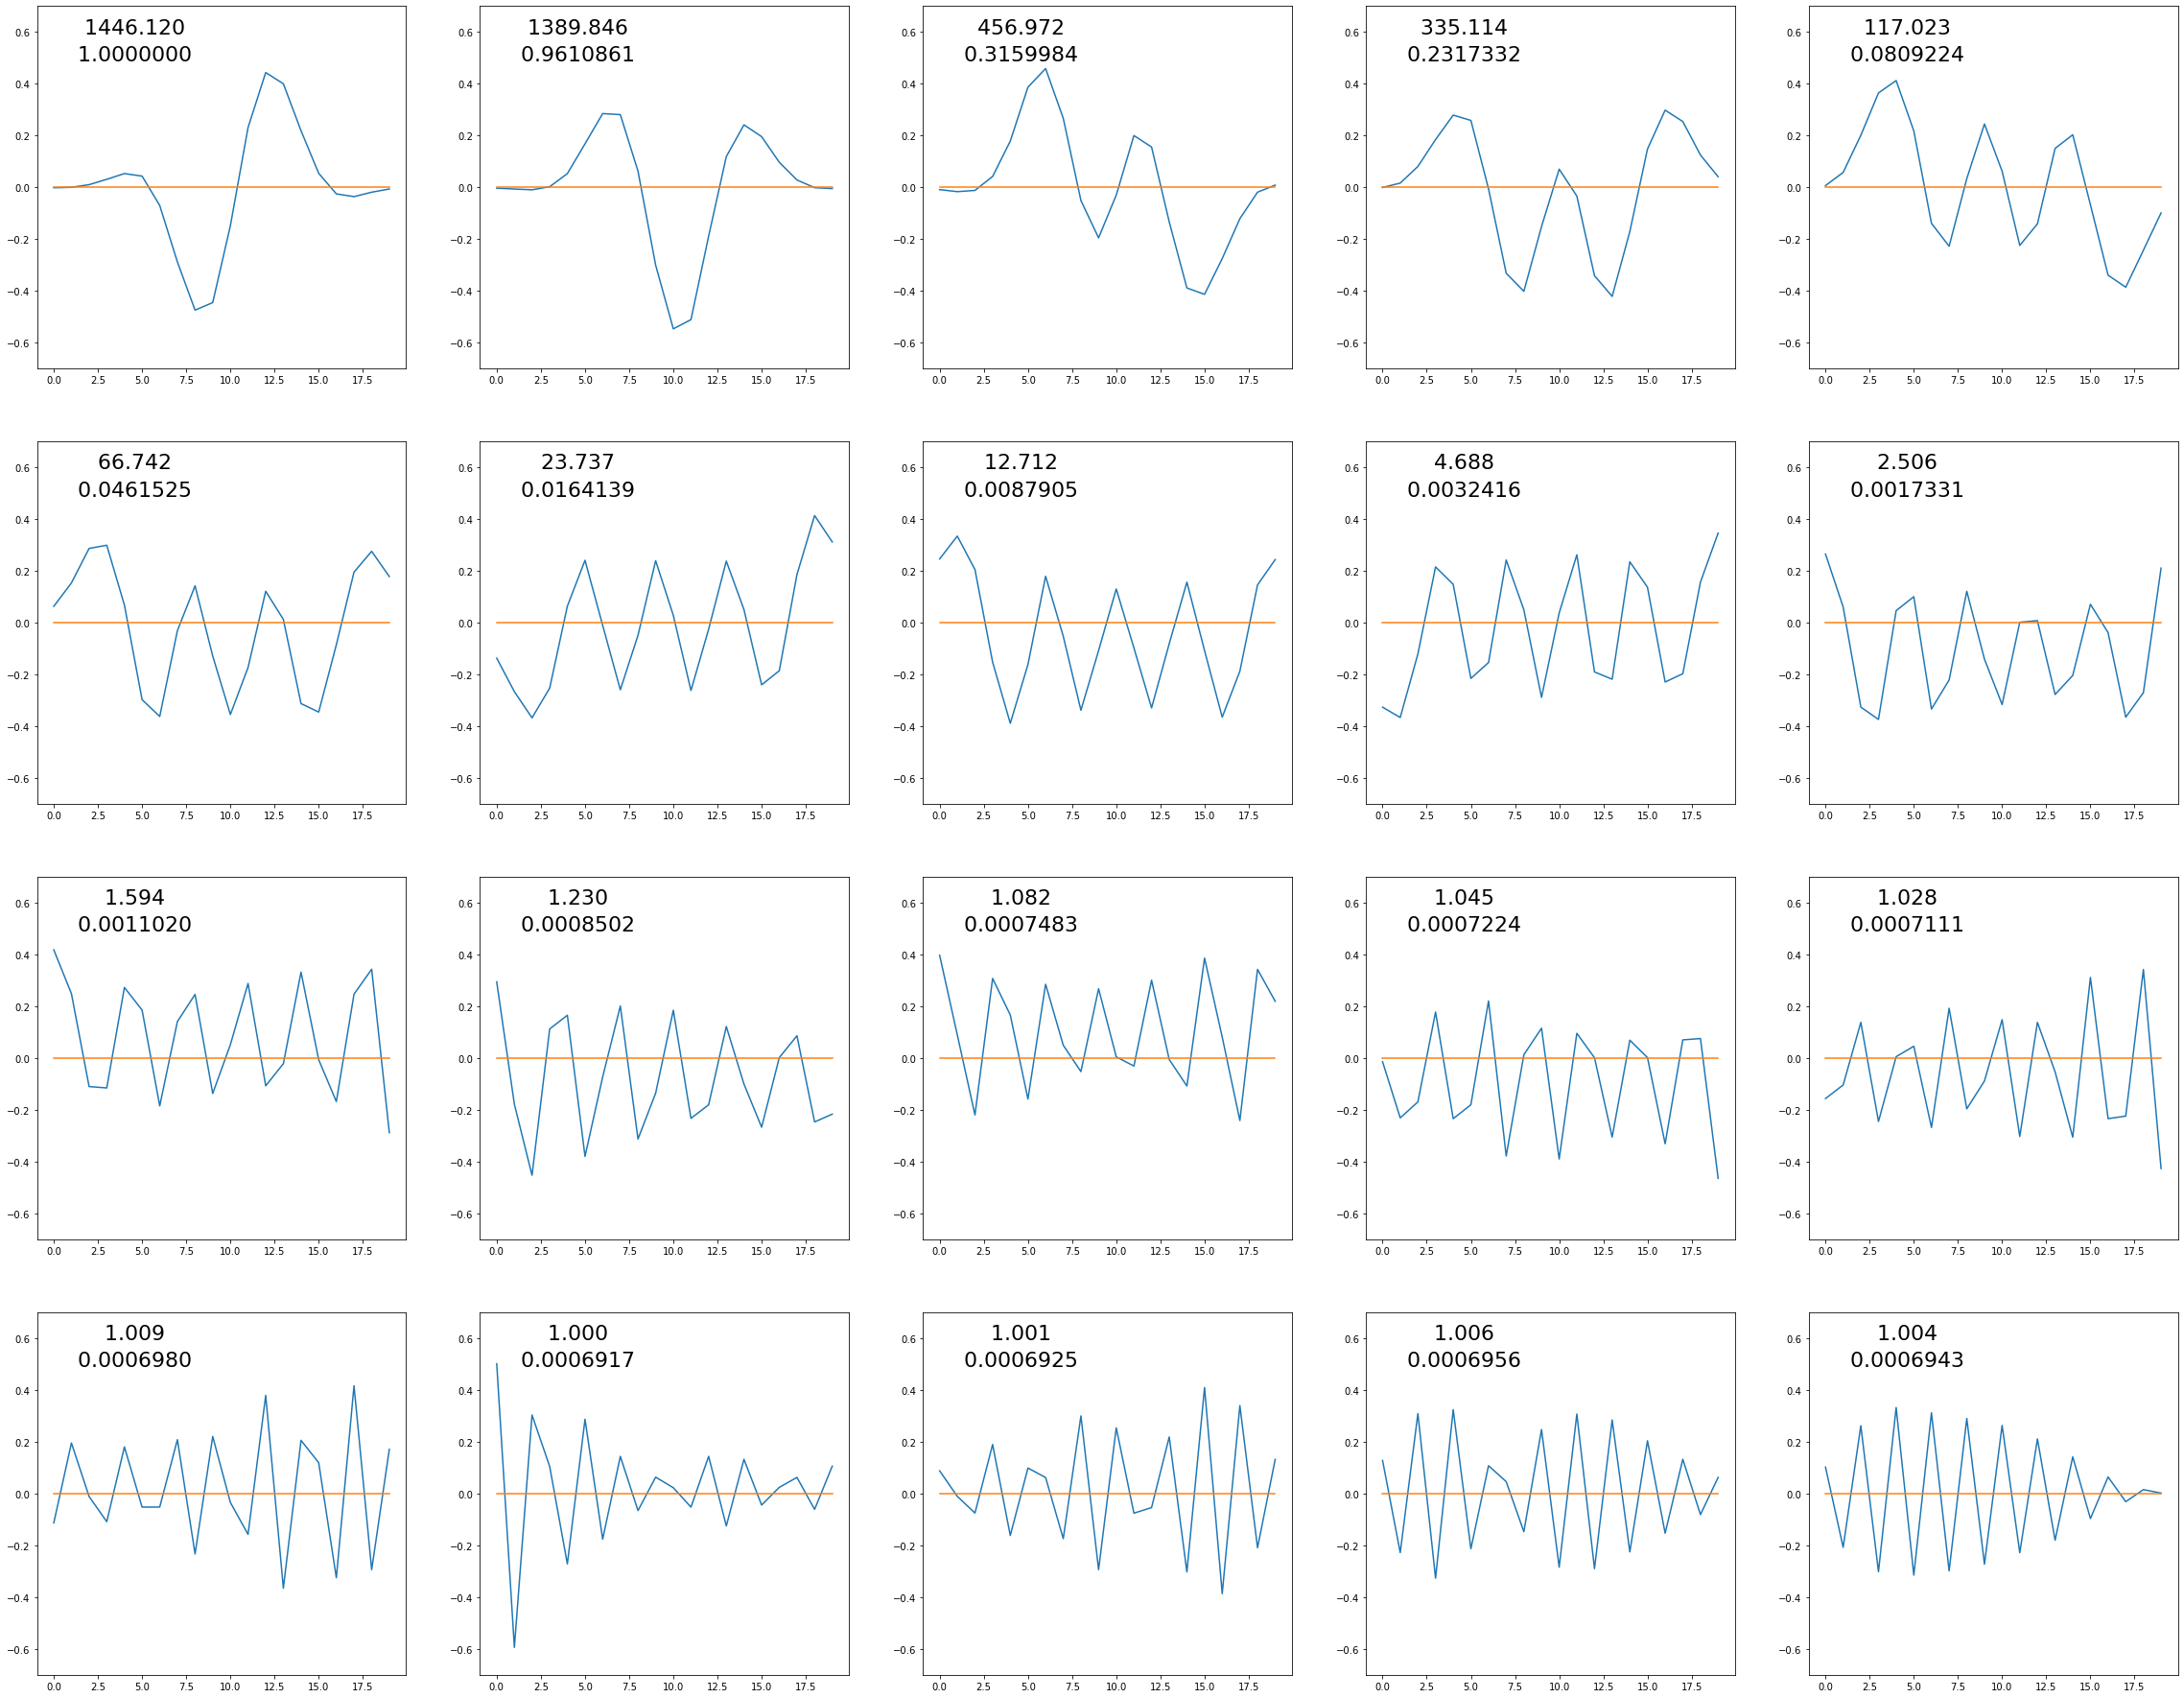

In [41]:
plot_ncols = 5
plot_nrows = int( len(cov_mat_evals) / plot_ncols )
print('\n\n N rows = %d, N cols = %d' % (plot_nrows, plot_ncols))

fig,ax = plt.subplots( plot_nrows, plot_ncols, figsize=(plot_ncols*8, plot_nrows*8))

for ri in range( plot_nrows ) :
    for ci in range( plot_ncols ) :
        
        evi = plot_ncols*ri + ci
        
        axi = ax[ri,ci]
        
        axi.plot(U[:,evi])
        
        axi.plot( np.zeros( len(cov_mat_evals) ))

        ymax = 0.7
        axi.set_ylim( -1*ymax, ymax )
        
        axi.text( 1, ymax * 0.85 , '%10.3f' % cov_mat_evals[evi], fontsize=22 )
        
        evratio = cov_mat_evals[evi]/cov_mat_evals[0]
        
        axi.text( 1, ymax * 0.70 , '%10.7f' % evratio, fontsize=22 )
        
plt.show

## Visualize what goes in to chi2 calc

In [42]:
vis_mat_pinv = np.zeros( shape=(hist_nbins, hist_nbins))
vis_mat_inv = np.zeros( shape=(hist_nbins, hist_nbins))

for i in range( hist_nbins ) :
    for j in range( hist_nbins ) :
        sigma_i = np.sqrt( hist_cov_mat[i,i] )
        sigma_j = np.sqrt( hist_cov_mat[j,j] )
        if i == j :
            vis_mat_pinv[i,i] = sigma_i * sigma_i * hist_cov_pinv[i,i]
            vis_mat_inv[i,i] = sigma_i * sigma_i * hist_cov_inv[i,i]
        else :
            vis_mat_pinv[i,j] = 2. * sigma_i * sigma_j * hist_cov_pinv[i,j]
            vis_mat_inv[i,j] = 2. * sigma_i * sigma_j * hist_cov_inv[i,j]


vis_pinv_min = np.min(vis_mat_pinv)
vis_pinv_max = np.max(vis_mat_pinv)
print('\n\n min and max of vis matrix, pinv :  %.2f  %.2f\n\n' % (vis_pinv_min, vis_pinv_max))
vis_mat_pinv_copy = np.copy( vis_mat_pinv )
vis_mat_pinv_copy[0,hist_nbins-1] = -1. * vis_pinv_max


vis_inv_min = np.min(vis_mat_inv)
vis_inv_max = np.max(vis_mat_inv)
print('\n\n min and max of vis matrix, inv :  %.2f  %.2f\n\n' % (vis_inv_min, vis_inv_max))
vis_mat_inv_copy = np.copy( vis_mat_inv )
vis_mat_inv_copy[0,hist_nbins-1] = -1. * vis_inv_max





 min and max of vis matrix, pinv :  -39.22  48.00




 min and max of vis matrix, inv :  -258.39  208.11




<function matplotlib.pyplot.show(close=None, block=None)>

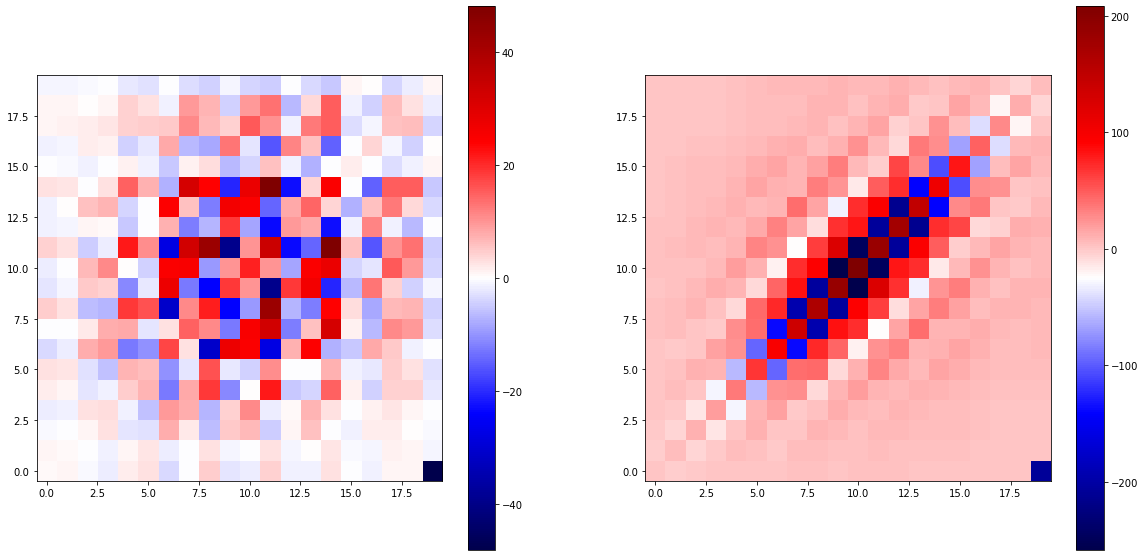

In [43]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_vis_mat_pinv = ax[0].imshow(vis_mat_pinv_copy,  cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_vis_mat_pinv, ax=ax[0] )

im_vis_mat_inv = ax[1].imshow(vis_mat_inv_copy,  cmap='seismic', origin='lower')
ax[1].figure.colorbar( im_vis_mat_inv, ax=ax[1] )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

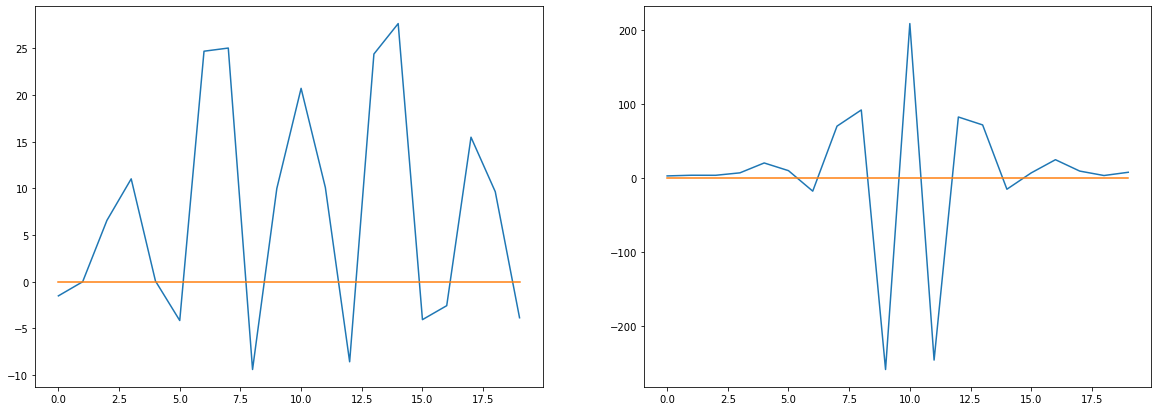

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,7))

ibin = 10

ax[0].plot( vis_mat_pinv[:,ibin])
ax[0].plot( np.zeros( hist_nbins ))

ax[1].plot( vis_mat_inv[:,ibin])
ax[1].plot( np.zeros( hist_nbins ))

plt.show

In [45]:
for bi in range( hist_nbins ) :
    for bj in range( hist_nbins ) :
        print('  %3d, %3d:   inv = %8.3f   pinv = %8.3f' % (bi, bj, hist_cov_inv[bi,bj], hist_cov_pinv[bi,bj]))

    0,   0:   inv =    0.701   pinv =    0.166
    0,   1:   inv =   -0.254   pinv =    0.105
    0,   2:   inv =   -0.045   pinv =   -0.048
    0,   3:   inv =    0.097   pinv =   -0.086
    0,   4:   inv =    0.066   pinv =    0.058
    0,   5:   inv =    0.014   pinv =    0.069
    0,   6:   inv =    0.023   pinv =   -0.070
    0,   7:   inv =    0.047   pinv =   -0.003
    0,   8:   inv =    0.033   pinv =    0.068
    0,   9:   inv =    0.028   pinv =   -0.034
    0,  10:   inv =    0.036   pinv =   -0.020
    0,  11:   inv =    0.035   pinv =    0.057
    0,  12:   inv =    0.034   pinv =   -0.020
    0,  13:   inv =    0.032   pinv =   -0.023
    0,  14:   inv =    0.035   pinv =    0.052
    0,  15:   inv =    0.041   pinv =   -0.005
    0,  16:   inv =    0.034   pinv =   -0.038
    0,  17:   inv =    0.027   pinv =    0.035
    0,  18:   inv =    0.040   pinv =    0.051
    0,  19:   inv =    0.078   pinv =   -0.074
    1,   0:   inv =   -0.254   pinv =    0.105
    1,   1:  

In [46]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [47]:
hist_cov_mat_diagonal

array([[  3.08633707,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   6.67809879,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  17.44976343,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

In [48]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
print(hist_cov_inv_diagonal)

[[0.32400868 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.14974322 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05730737 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02628249 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01395071 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [49]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

xMin = hist_xlow
xMax = hist_xhigh

In [50]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [51]:
# Initialize Minuit and set up fit:
theta = 1
mu = 0.2
sigma2 = 0.81
#fitType = 'bin center approximation'
#fitType = 'integral within bin'

parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma2']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
parfix  = [False, False, False]            # change to fix/free param.
parlim  = [(0.5, 1.5), (None, None), (0., None)]

chisq = ChiSquared(boot_hist_content[0,:], hist_bin_edges, hist_cov_pinv, fitType, 1)
chisq_diag = ChiSquared(boot_hist_content[0,:], hist_bin_edges, hist_cov_inv_diagonal, fitType, 1)


m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1


m_diag = Minuit(chisq_diag, parin, name=parname)
m_diag.errors = parstep
m_diag.fixed = parfix
m_diag.limits = parlim
m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1



 setData:
  numVal:       9982.7  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


 setData:
  numVal:       9982.7  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


In [52]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

m_diag.migrad()                                        # minimize -logL
parhat_diag = m_diag.values                                 # max-likelihood estimates
sigma_parhat_diag = m_diag.errors                           # standard deviations
cov_diag = m_diag.covariance                                # covariance matrix
rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.




In [53]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:

        print(' %2d %-10s  =  %7.4f +/- %7.4f ,   diagonal cov result = %7.4f +/- %7.4f' %
              (i, m.parameters[i], parhat[i], sigma_parhat[i],
              parhat_diag[i], sigma_parhat_diag[i])
             )
            
            
            
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:9.6f}".format(cov[i,j]), "{:9.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = hist_nbins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
  0 theta       =   1.0000 +/-  0.0010 ,   diagonal cov result =  1.0007 +/-  0.0062
  1 mu          =   0.1868 +/-  0.0106 ,   diagonal cov result =  0.1879 +/-  0.0060
  2 sigma2      =   0.8189 +/-  0.0156 ,   diagonal cov result =  0.8150 +/-  0.0081

free par indices, covariance, correlation coeff.:
0 0  0.000001  1.000000
0 1 -0.000000 -0.040627
0 2  0.000001  0.063145
1 0 -0.000000 -0.040627
1 1  0.000111  1.000000
1 2  0.000013  0.076905
2 0  0.000001  0.063145
2 1  0.000013  0.076905
2 2  0.000242  1.000000
chi2min =  19.773151567989217 ,     ndof =  16
pval =  0.23061204983512706


In [54]:
boot_hist_content.shape

(5000, 20)

In [55]:
len(boot_hist_content)

5000

In [56]:
nfits = len(boot_hist_content)
#nfits = 500
if nfits > 5000 : nfits = 5000

In [57]:

chi2_fit_mu_val = np.zeros( nfits )
chi2_fit_mu_err = np.zeros( nfits )

chi2_fit_sig2_val = np.zeros( nfits )
chi2_fit_sig2_err = np.zeros( nfits )

chi2_fit_diag_mu_val = np.zeros( nfits )
chi2_fit_diag_mu_err = np.zeros( nfits )

chi2_fit_diag_sig2_val = np.zeros( nfits )
chi2_fit_diag_sig2_err = np.zeros( nfits )





for si in range( nfits ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1868 +/-   0.0106  (  0.1879 +/-   0.0060)    sig2   0.8189 +/-   0.0156  (  0.8150 +/-   0.0081)
   1 : mu   0.1910 +/-   0.0105  (  0.1922 +/-   0.0060)    sig2   0.8144 +/-   0.0157  (  0.8026 +/-   0.0082)
   2 : mu   0.1860 +/-   0.0105  (  0.1889 +/-   0.0060)    sig2   0.8373 +/-   0.0158  (  0.8278 +/-   0.0083)
   3 : mu   0.1991 +/-   0.0105  (  0.2027 +/-   0.0060)    sig2   0.8054 +/-   0.0159  (  0.7892 +/-   0.0082)
   4 : mu   0.2027 +/-   0.0105  (  0.2057 +/-   0.0060)    sig2   0.8057 +/-   0.0155  (  0.7995 +/-   0.0081)
   5 : mu   0.1911 +/-   0.0105  (  0.1946 +/-   0.0060)    sig2   0.8442 +/-   0.0159  (  0.8331 +/-   0.0082)
   6 : mu   0.1978 +/-   0.0105  (  0.2008 +/-   0.0060)    sig2   0.8296 +/-   0.0159  (  0.8182 +/-   0.0082)
   7 : mu   0.1890 +/-   0.0105  (  0.1916 +/-   0.0060)    sig2   0.8227 +/-   0.0157  (  0.8098 +/-   0.0082)
   8 : mu   0.1927 +/-   0.0105  (  0.1959 +/-   0.0060)    sig2   0.8147 +/-   0.0154  (  0.8044 +/-   

  88 : mu   0.1866 +/-   0.0105  (  0.1870 +/-   0.0060)    sig2   0.8084 +/-   0.0158  (  0.7947 +/-   0.0082)
  89 : mu   0.1804 +/-   0.0105  (  0.1820 +/-   0.0060)    sig2   0.8255 +/-   0.0158  (  0.8140 +/-   0.0083)
  90 : mu   0.2070 +/-   0.0105  (  0.2122 +/-   0.0060)    sig2   0.7908 +/-   0.0155  (  0.7817 +/-   0.0081)
  91 : mu   0.2042 +/-   0.0105  (  0.2058 +/-   0.0060)    sig2   0.8234 +/-   0.0160  (  0.8098 +/-   0.0083)
  92 : mu   0.2095 +/-   0.0105  (  0.2105 +/-   0.0060)    sig2   0.8244 +/-   0.0156  (  0.8129 +/-   0.0081)
  93 : mu   0.2060 +/-   0.0105  (  0.2116 +/-   0.0060)    sig2   0.8335 +/-   0.0159  (  0.8234 +/-   0.0083)
  94 : mu   0.2151 +/-   0.0105  (  0.2171 +/-   0.0060)    sig2   0.8198 +/-   0.0155  (  0.8124 +/-   0.0081)
  95 : mu   0.2019 +/-   0.0105  (  0.2064 +/-   0.0060)    sig2   0.8358 +/-   0.0156  (  0.8270 +/-   0.0081)
  96 : mu   0.2050 +/-   0.0105  (  0.2090 +/-   0.0060)    sig2   0.8262 +/-   0.0153  (  0.8195 +/-   

 200 : mu   0.1945 +/-   0.0105  (  0.1956 +/-   0.0060)    sig2   0.8317 +/-   0.0159  (  0.8176 +/-   0.0082)
 201 : mu   0.2019 +/-   0.0105  (  0.2058 +/-   0.0060)    sig2   0.8327 +/-   0.0153  (  0.8290 +/-   0.0080)
 202 : mu   0.2059 +/-   0.0105  (  0.2090 +/-   0.0060)    sig2   0.8132 +/-   0.0154  (  0.8043 +/-   0.0080)
 203 : mu   0.2016 +/-   0.0105  (  0.2066 +/-   0.0060)    sig2   0.8191 +/-   0.0157  (  0.8060 +/-   0.0082)
 204 : mu   0.2092 +/-   0.0105  (  0.2122 +/-   0.0060)    sig2   0.8424 +/-   0.0156  (  0.8359 +/-   0.0082)
 205 : mu   0.2106 +/-   0.0105  (  0.2129 +/-   0.0060)    sig2   0.8346 +/-   0.0159  (  0.8243 +/-   0.0083)
 206 : mu   0.1971 +/-   0.0105  (  0.1994 +/-   0.0060)    sig2   0.8018 +/-   0.0157  (  0.7894 +/-   0.0081)
 207 : mu   0.1796 +/-   0.0105  (  0.1833 +/-   0.0060)    sig2   0.8210 +/-   0.0155  (  0.8136 +/-   0.0082)
 208 : mu   0.1931 +/-   0.0105  (  0.1944 +/-   0.0060)    sig2   0.8335 +/-   0.0158  (  0.8254 +/-   

 312 : mu   0.1931 +/-   0.0105  (  0.1976 +/-   0.0060)    sig2   0.8127 +/-   0.0156  (  0.8037 +/-   0.0081)
 313 : mu   0.1969 +/-   0.0105  (  0.1984 +/-   0.0060)    sig2   0.8333 +/-   0.0159  (  0.8191 +/-   0.0082)
 314 : mu   0.1752 +/-   0.0105  (  0.1792 +/-   0.0060)    sig2   0.8082 +/-   0.0151  (  0.8020 +/-   0.0079)
 315 : mu   0.2108 +/-   0.0105  (  0.2131 +/-   0.0060)    sig2   0.7914 +/-   0.0152  (  0.7856 +/-   0.0079)
 316 : mu   0.1907 +/-   0.0105  (  0.1938 +/-   0.0059)    sig2   0.7924 +/-   0.0155  (  0.7847 +/-   0.0080)
 317 : mu   0.2036 +/-   0.0105  (  0.2057 +/-   0.0060)    sig2   0.7977 +/-   0.0156  (  0.7865 +/-   0.0081)
 318 : mu   0.1872 +/-   0.0105  (  0.1908 +/-   0.0060)    sig2   0.8524 +/-   0.0157  (  0.8447 +/-   0.0082)
 319 : mu   0.1973 +/-   0.0105  (  0.1988 +/-   0.0060)    sig2   0.8263 +/-   0.0156  (  0.8161 +/-   0.0081)
 320 : mu   0.1983 +/-   0.0106  (  0.1968 +/-   0.0060)    sig2   0.8356 +/-   0.0161  (  0.8178 +/-   

 425 : mu   0.1832 +/-   0.0105  (  0.1848 +/-   0.0060)    sig2   0.8386 +/-   0.0160  (  0.8260 +/-   0.0083)
 426 : mu   0.1923 +/-   0.0105  (  0.1935 +/-   0.0060)    sig2   0.8390 +/-   0.0159  (  0.8240 +/-   0.0083)
 427 : mu   0.2044 +/-   0.0105  (  0.2088 +/-   0.0060)    sig2   0.8329 +/-   0.0156  (  0.8256 +/-   0.0082)
 428 : mu   0.2117 +/-   0.0105  (  0.2141 +/-   0.0060)    sig2   0.8396 +/-   0.0161  (  0.8227 +/-   0.0083)
 429 : mu   0.1836 +/-   0.0105  (  0.1870 +/-   0.0060)    sig2   0.8239 +/-   0.0153  (  0.8150 +/-   0.0080)
 430 : mu   0.1929 +/-   0.0105  (  0.1943 +/-   0.0059)    sig2   0.7807 +/-   0.0154  (  0.7703 +/-   0.0080)
 431 : mu   0.2020 +/-   0.0105  (  0.2070 +/-   0.0060)    sig2   0.8313 +/-   0.0158  (  0.8155 +/-   0.0082)
 432 : mu   0.1965 +/-   0.0105  (  0.1987 +/-   0.0060)    sig2   0.8243 +/-   0.0160  (  0.8122 +/-   0.0083)
 433 : mu   0.1846 +/-   0.0105  (  0.1875 +/-   0.0060)    sig2   0.8498 +/-   0.0162  (  0.8299 +/-   

 537 : mu   0.1855 +/-   0.0105  (  0.1903 +/-   0.0059)    sig2   0.7935 +/-   0.0152  (  0.7857 +/-   0.0079)
 538 : mu   0.1956 +/-   0.0105  (  0.1971 +/-   0.0060)    sig2   0.8091 +/-   0.0158  (  0.7975 +/-   0.0082)
 539 : mu   0.2071 +/-   0.0105  (  0.2112 +/-   0.0060)    sig2   0.8127 +/-   0.0154  (  0.8054 +/-   0.0080)
 540 : mu   0.1766 +/-   0.0105  (  0.1777 +/-   0.0060)    sig2   0.8222 +/-   0.0158  (  0.8103 +/-   0.0082)
 541 : mu   0.1860 +/-   0.0105  (  0.1870 +/-   0.0059)    sig2   0.8015 +/-   0.0161  (  0.7830 +/-   0.0083)
 542 : mu   0.2077 +/-   0.0105  (  0.2125 +/-   0.0060)    sig2   0.8392 +/-   0.0157  (  0.8335 +/-   0.0082)
 543 : mu   0.2164 +/-   0.0105  (  0.2213 +/-   0.0060)    sig2   0.8065 +/-   0.0155  (  0.7968 +/-   0.0081)
 544 : mu   0.1932 +/-   0.0105  (  0.1945 +/-   0.0060)    sig2   0.8309 +/-   0.0158  (  0.8169 +/-   0.0082)
 545 : mu   0.2116 +/-   0.0105  (  0.2156 +/-   0.0060)    sig2   0.8260 +/-   0.0158  (  0.8114 +/-   

 650 : mu   0.2151 +/-   0.0105  (  0.2168 +/-   0.0060)    sig2   0.8102 +/-   0.0156  (  0.8031 +/-   0.0081)
 651 : mu   0.1952 +/-   0.0105  (  0.1990 +/-   0.0060)    sig2   0.8212 +/-   0.0155  (  0.8139 +/-   0.0080)
 652 : mu   0.2199 +/-   0.0105  (  0.2229 +/-   0.0060)    sig2   0.8398 +/-   0.0158  (  0.8294 +/-   0.0082)
 653 : mu   0.1907 +/-   0.0105  (  0.1924 +/-   0.0060)    sig2   0.8126 +/-   0.0155  (  0.8047 +/-   0.0081)
 654 : mu   0.2031 +/-   0.0105  (  0.2063 +/-   0.0060)    sig2   0.8299 +/-   0.0159  (  0.8173 +/-   0.0082)
 655 : mu   0.1943 +/-   0.0105  (  0.1954 +/-   0.0060)    sig2   0.8456 +/-   0.0157  (  0.8403 +/-   0.0082)
 656 : mu   0.2178 +/-   0.0105  (  0.2207 +/-   0.0060)    sig2   0.8115 +/-   0.0159  (  0.7977 +/-   0.0083)
 657 : mu   0.2000 +/-   0.0105  (  0.2018 +/-   0.0060)    sig2   0.8158 +/-   0.0149  (  0.8146 +/-   0.0078)
 658 : mu   0.1930 +/-   0.0105  (  0.1926 +/-   0.0060)    sig2   0.8259 +/-   0.0158  (  0.8116 +/-   

 762 : mu   0.1848 +/-   0.0105  (  0.1887 +/-   0.0060)    sig2   0.8091 +/-   0.0156  (  0.8012 +/-   0.0081)
 763 : mu   0.1979 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.8092 +/-   0.0156  (  0.7991 +/-   0.0081)
 764 : mu   0.2136 +/-   0.0105  (  0.2159 +/-   0.0060)    sig2   0.8264 +/-   0.0159  (  0.8112 +/-   0.0082)
 765 : mu   0.1997 +/-   0.0105  (  0.2024 +/-   0.0060)    sig2   0.8356 +/-   0.0158  (  0.8271 +/-   0.0082)
 766 : mu   0.1866 +/-   0.0105  (  0.1899 +/-   0.0060)    sig2   0.7989 +/-   0.0154  (  0.7902 +/-   0.0080)
 767 : mu   0.1965 +/-   0.0105  (  0.1987 +/-   0.0060)    sig2   0.8128 +/-   0.0153  (  0.8048 +/-   0.0079)
 768 : mu   0.1837 +/-   0.0105  (  0.1874 +/-   0.0060)    sig2   0.8007 +/-   0.0154  (  0.7932 +/-   0.0079)
 769 : mu   0.2066 +/-   0.0105  (  0.2097 +/-   0.0060)    sig2   0.8128 +/-   0.0156  (  0.8030 +/-   0.0081)
 770 : mu   0.2057 +/-   0.0105  (  0.2107 +/-   0.0060)    sig2   0.8150 +/-   0.0160  (  0.8037 +/-   

 874 : mu   0.2051 +/-   0.0105  (  0.2081 +/-   0.0060)    sig2   0.7986 +/-   0.0153  (  0.7923 +/-   0.0080)
 875 : mu   0.2097 +/-   0.0105  (  0.2130 +/-   0.0060)    sig2   0.8051 +/-   0.0156  (  0.7977 +/-   0.0081)
 876 : mu   0.2091 +/-   0.0105  (  0.2102 +/-   0.0060)    sig2   0.8233 +/-   0.0156  (  0.8162 +/-   0.0081)
 877 : mu   0.1906 +/-   0.0105  (  0.1924 +/-   0.0060)    sig2   0.8158 +/-   0.0154  (  0.8075 +/-   0.0081)
 878 : mu   0.1945 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.8237 +/-   0.0156  (  0.8127 +/-   0.0081)
 879 : mu   0.2004 +/-   0.0105  (  0.2030 +/-   0.0060)    sig2   0.8308 +/-   0.0157  (  0.8233 +/-   0.0082)
 880 : mu   0.2014 +/-   0.0105  (  0.2038 +/-   0.0060)    sig2   0.8259 +/-   0.0158  (  0.8143 +/-   0.0082)
 881 : mu   0.1824 +/-   0.0105  (  0.1855 +/-   0.0060)    sig2   0.8366 +/-   0.0161  (  0.8179 +/-   0.0084)
 882 : mu   0.1934 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.8235 +/-   0.0156  (  0.8132 +/-   

 948 : mu   0.1871 +/-   0.0105  (  0.1906 +/-   0.0060)    sig2   0.8027 +/-   0.0153  (  0.7953 +/-   0.0080)
 949 : mu   0.1972 +/-   0.0105  (  0.2008 +/-   0.0060)    sig2   0.8077 +/-   0.0155  (  0.7990 +/-   0.0080)
 950 : mu   0.2112 +/-   0.0105  (  0.2128 +/-   0.0060)    sig2   0.8540 +/-   0.0163  (  0.8390 +/-   0.0084)
 951 : mu   0.2055 +/-   0.0105  (  0.2079 +/-   0.0060)    sig2   0.8088 +/-   0.0155  (  0.7991 +/-   0.0081)
 952 : mu   0.1972 +/-   0.0105  (  0.2012 +/-   0.0060)    sig2   0.8568 +/-   0.0159  (  0.8436 +/-   0.0082)
 953 : mu   0.1831 +/-   0.0105  (  0.1859 +/-   0.0060)    sig2   0.8179 +/-   0.0161  (  0.8016 +/-   0.0083)
 954 : mu   0.2084 +/-   0.0105  (  0.2099 +/-   0.0060)    sig2   0.8452 +/-   0.0157  (  0.8364 +/-   0.0081)
 955 : mu   0.2025 +/-   0.0105  (  0.2057 +/-   0.0060)    sig2   0.7952 +/-   0.0154  (  0.7868 +/-   0.0080)
 956 : mu   0.1940 +/-   0.0105  (  0.1953 +/-   0.0060)    sig2   0.8365 +/-   0.0156  (  0.8236 +/-   

 1043 : mu   0.1937 +/-   0.0105  (  0.1960 +/-   0.0060)    sig2   0.8070 +/-   0.0156  (  0.7936 +/-   0.0081)
 1044 : mu   0.1951 +/-   0.0105  (  0.1997 +/-   0.0060)    sig2   0.8341 +/-   0.0157  (  0.8292 +/-   0.0082)
 1045 : mu   0.2070 +/-   0.0105  (  0.2106 +/-   0.0060)    sig2   0.8461 +/-   0.0156  (  0.8394 +/-   0.0082)
 1046 : mu   0.1871 +/-   0.0105  (  0.1924 +/-   0.0060)    sig2   0.8270 +/-   0.0156  (  0.8172 +/-   0.0081)
 1047 : mu   0.1897 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.8120 +/-   0.0155  (  0.8071 +/-   0.0081)
 1048 : mu   0.1940 +/-   0.0105  (  0.1966 +/-   0.0060)    sig2   0.8102 +/-   0.0160  (  0.7951 +/-   0.0082)
 1049 : mu   0.1964 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.8098 +/-   0.0159  (  0.7973 +/-   0.0083)
 1050 : mu   0.1928 +/-   0.0105  (  0.1967 +/-   0.0060)    sig2   0.8249 +/-   0.0156  (  0.8140 +/-   0.0081)
 1051 : mu   0.1896 +/-   0.0105  (  0.1911 +/-   0.0060)    sig2   0.8289 +/-   0.0158  (  0.81

 1116 : mu   0.2200 +/-   0.0105  (  0.2233 +/-   0.0060)    sig2   0.8307 +/-   0.0159  (  0.8138 +/-   0.0082)
 1117 : mu   0.2038 +/-   0.0105  (  0.2068 +/-   0.0060)    sig2   0.8528 +/-   0.0159  (  0.8435 +/-   0.0083)
 1118 : mu   0.1752 +/-   0.0105  (  0.1767 +/-   0.0060)    sig2   0.8061 +/-   0.0157  (  0.7963 +/-   0.0081)
 1119 : mu   0.2099 +/-   0.0105  (  0.2123 +/-   0.0060)    sig2   0.8299 +/-   0.0157  (  0.8235 +/-   0.0082)
 1120 : mu   0.2101 +/-   0.0105  (  0.2110 +/-   0.0060)    sig2   0.8252 +/-   0.0157  (  0.8163 +/-   0.0081)
 1121 : mu   0.2121 +/-   0.0105  (  0.2155 +/-   0.0060)    sig2   0.8218 +/-   0.0158  (  0.8075 +/-   0.0082)
 1122 : mu   0.1901 +/-   0.0105  (  0.1899 +/-   0.0060)    sig2   0.8280 +/-   0.0159  (  0.8139 +/-   0.0082)
 1123 : mu   0.2013 +/-   0.0105  (  0.2021 +/-   0.0060)    sig2   0.8190 +/-   0.0157  (  0.8064 +/-   0.0081)
 1124 : mu   0.1953 +/-   0.0105  (  0.1948 +/-   0.0060)    sig2   0.8262 +/-   0.0160  (  0.81

 1211 : mu   0.1953 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.8343 +/-   0.0157  (  0.8247 +/-   0.0082)
 1212 : mu   0.2005 +/-   0.0105  (  0.2032 +/-   0.0060)    sig2   0.7945 +/-   0.0153  (  0.7866 +/-   0.0079)
 1213 : mu   0.1911 +/-   0.0105  (  0.1936 +/-   0.0060)    sig2   0.8189 +/-   0.0155  (  0.8112 +/-   0.0080)
 1214 : mu   0.2004 +/-   0.0105  (  0.2016 +/-   0.0060)    sig2   0.8126 +/-   0.0156  (  0.8022 +/-   0.0080)
 1215 : mu   0.1802 +/-   0.0105  (  0.1820 +/-   0.0060)    sig2   0.8174 +/-   0.0158  (  0.8012 +/-   0.0082)
 1216 : mu   0.1865 +/-   0.0105  (  0.1889 +/-   0.0060)    sig2   0.8178 +/-   0.0156  (  0.8094 +/-   0.0081)
 1217 : mu   0.2086 +/-   0.0105  (  0.2094 +/-   0.0060)    sig2   0.8126 +/-   0.0157  (  0.7999 +/-   0.0082)
 1218 : mu   0.1992 +/-   0.0105  (  0.2005 +/-   0.0060)    sig2   0.8125 +/-   0.0153  (  0.8076 +/-   0.0080)
 1219 : mu   0.1896 +/-   0.0105  (  0.1899 +/-   0.0059)    sig2   0.7882 +/-   0.0156  (  0.77

 1284 : mu   0.2065 +/-   0.0105  (  0.2089 +/-   0.0060)    sig2   0.8066 +/-   0.0158  (  0.7980 +/-   0.0082)
 1285 : mu   0.2246 +/-   0.0105  (  0.2273 +/-   0.0060)    sig2   0.8125 +/-   0.0156  (  0.8031 +/-   0.0081)
 1286 : mu   0.1921 +/-   0.0105  (  0.1932 +/-   0.0060)    sig2   0.8055 +/-   0.0158  (  0.7982 +/-   0.0082)
 1287 : mu   0.1802 +/-   0.0105  (  0.1835 +/-   0.0060)    sig2   0.8310 +/-   0.0153  (  0.8288 +/-   0.0080)
 1288 : mu   0.2069 +/-   0.0105  (  0.2104 +/-   0.0060)    sig2   0.8455 +/-   0.0159  (  0.8383 +/-   0.0083)
 1289 : mu   0.2080 +/-   0.0105  (  0.2110 +/-   0.0060)    sig2   0.8270 +/-   0.0160  (  0.8152 +/-   0.0082)
 1290 : mu   0.1903 +/-   0.0106  (  0.1900 +/-   0.0060)    sig2   0.8598 +/-   0.0160  (  0.8479 +/-   0.0082)
 1291 : mu   0.1934 +/-   0.0105  (  0.1963 +/-   0.0059)    sig2   0.7964 +/-   0.0154  (  0.7842 +/-   0.0080)
 1292 : mu   0.2010 +/-   0.0105  (  0.2041 +/-   0.0060)    sig2   0.8073 +/-   0.0153  (  0.80

 1379 : mu   0.2009 +/-   0.0105  (  0.2035 +/-   0.0060)    sig2   0.8488 +/-   0.0161  (  0.8350 +/-   0.0083)
 1380 : mu   0.2034 +/-   0.0105  (  0.2040 +/-   0.0060)    sig2   0.8269 +/-   0.0159  (  0.8116 +/-   0.0082)
 1381 : mu   0.1984 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8402 +/-   0.0158  (  0.8270 +/-   0.0082)
 1382 : mu   0.1905 +/-   0.0105  (  0.1909 +/-   0.0060)    sig2   0.8083 +/-   0.0157  (  0.7974 +/-   0.0082)
 1383 : mu   0.2184 +/-   0.0105  (  0.2207 +/-   0.0060)    sig2   0.8018 +/-   0.0155  (  0.7910 +/-   0.0080)
 1384 : mu   0.1999 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8032 +/-   0.0159  (  0.7858 +/-   0.0082)
 1385 : mu   0.2007 +/-   0.0105  (  0.2001 +/-   0.0060)    sig2   0.7951 +/-   0.0156  (  0.7864 +/-   0.0081)
 1386 : mu   0.2045 +/-   0.0105  (  0.2077 +/-   0.0060)    sig2   0.8035 +/-   0.0155  (  0.7957 +/-   0.0081)
 1387 : mu   0.1990 +/-   0.0105  (  0.2011 +/-   0.0060)    sig2   0.8372 +/-   0.0157  (  0.82

 1452 : mu   0.2035 +/-   0.0105  (  0.2070 +/-   0.0060)    sig2   0.8334 +/-   0.0157  (  0.8239 +/-   0.0082)
 1453 : mu   0.1993 +/-   0.0105  (  0.2014 +/-   0.0060)    sig2   0.8129 +/-   0.0157  (  0.7939 +/-   0.0082)
 1454 : mu   0.1895 +/-   0.0105  (  0.1923 +/-   0.0060)    sig2   0.8313 +/-   0.0154  (  0.8252 +/-   0.0080)
 1455 : mu   0.2065 +/-   0.0105  (  0.2087 +/-   0.0060)    sig2   0.8207 +/-   0.0155  (  0.8128 +/-   0.0080)
 1456 : mu   0.1925 +/-   0.0105  (  0.1949 +/-   0.0060)    sig2   0.8180 +/-   0.0156  (  0.8073 +/-   0.0081)
 1457 : mu   0.2129 +/-   0.0105  (  0.2152 +/-   0.0060)    sig2   0.8353 +/-   0.0157  (  0.8272 +/-   0.0082)
 1458 : mu   0.2034 +/-   0.0105  (  0.2067 +/-   0.0060)    sig2   0.8261 +/-   0.0154  (  0.8186 +/-   0.0080)
 1459 : mu   0.2012 +/-   0.0105  (  0.2035 +/-   0.0060)    sig2   0.8085 +/-   0.0155  (  0.7973 +/-   0.0081)
 1460 : mu   0.2053 +/-   0.0105  (  0.2085 +/-   0.0060)    sig2   0.8193 +/-   0.0155  (  0.80

 1548 : mu   0.2019 +/-   0.0105  (  0.2024 +/-   0.0060)    sig2   0.8243 +/-   0.0154  (  0.8176 +/-   0.0080)
 1549 : mu   0.2042 +/-   0.0105  (  0.2064 +/-   0.0060)    sig2   0.8372 +/-   0.0158  (  0.8281 +/-   0.0082)
 1550 : mu   0.1996 +/-   0.0105  (  0.2009 +/-   0.0060)    sig2   0.8288 +/-   0.0159  (  0.8153 +/-   0.0082)
 1551 : mu   0.1891 +/-   0.0105  (  0.1906 +/-   0.0060)    sig2   0.8632 +/-   0.0156  (  0.8545 +/-   0.0081)
 1552 : mu   0.2069 +/-   0.0106  (  0.2080 +/-   0.0060)    sig2   0.8293 +/-   0.0156  (  0.8213 +/-   0.0081)
 1553 : mu   0.2021 +/-   0.0105  (  0.2051 +/-   0.0060)    sig2   0.8334 +/-   0.0155  (  0.8255 +/-   0.0081)
 1554 : mu   0.2037 +/-   0.0105  (  0.2085 +/-   0.0060)    sig2   0.8402 +/-   0.0160  (  0.8291 +/-   0.0083)
 1555 : mu   0.1928 +/-   0.0105  (  0.1976 +/-   0.0060)    sig2   0.8319 +/-   0.0156  (  0.8241 +/-   0.0082)
 1556 : mu   0.2153 +/-   0.0105  (  0.2179 +/-   0.0060)    sig2   0.8083 +/-   0.0157  (  0.79

 1622 : mu   0.2036 +/-   0.0105  (  0.2060 +/-   0.0060)    sig2   0.8054 +/-   0.0157  (  0.7925 +/-   0.0082)
 1623 : mu   0.1960 +/-   0.0105  (  0.1981 +/-   0.0060)    sig2   0.8133 +/-   0.0154  (  0.8068 +/-   0.0080)
 1624 : mu   0.1996 +/-   0.0105  (  0.2012 +/-   0.0060)    sig2   0.8161 +/-   0.0155  (  0.8061 +/-   0.0081)
 1625 : mu   0.1829 +/-   0.0105  (  0.1827 +/-   0.0060)    sig2   0.8087 +/-   0.0160  (  0.7927 +/-   0.0082)
 1626 : mu   0.2099 +/-   0.0105  (  0.2119 +/-   0.0060)    sig2   0.8182 +/-   0.0155  (  0.8124 +/-   0.0080)
 1627 : mu   0.2046 +/-   0.0105  (  0.2061 +/-   0.0060)    sig2   0.8026 +/-   0.0155  (  0.7927 +/-   0.0081)
 1628 : mu   0.2017 +/-   0.0105  (  0.2048 +/-   0.0060)    sig2   0.8048 +/-   0.0157  (  0.7946 +/-   0.0082)
 1629 : mu   0.2028 +/-   0.0105  (  0.2039 +/-   0.0060)    sig2   0.8150 +/-   0.0155  (  0.8070 +/-   0.0080)
 1630 : mu   0.1822 +/-   0.0105  (  0.1848 +/-   0.0060)    sig2   0.8097 +/-   0.0157  (  0.80

 1717 : mu   0.1891 +/-   0.0105  (  0.1915 +/-   0.0060)    sig2   0.8491 +/-   0.0157  (  0.8390 +/-   0.0082)
 1718 : mu   0.1968 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.8114 +/-   0.0156  (  0.8020 +/-   0.0081)
 1719 : mu   0.1913 +/-   0.0105  (  0.1927 +/-   0.0059)    sig2   0.7807 +/-   0.0156  (  0.7712 +/-   0.0081)
 1720 : mu   0.1927 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.8340 +/-   0.0157  (  0.8251 +/-   0.0082)
 1721 : mu   0.1910 +/-   0.0105  (  0.1917 +/-   0.0060)    sig2   0.8311 +/-   0.0155  (  0.8251 +/-   0.0080)
 1722 : mu   0.1998 +/-   0.0105  (  0.2032 +/-   0.0060)    sig2   0.8062 +/-   0.0158  (  0.7917 +/-   0.0082)
 1723 : mu   0.1957 +/-   0.0105  (  0.2005 +/-   0.0060)    sig2   0.8266 +/-   0.0153  (  0.8174 +/-   0.0080)
 1724 : mu   0.2103 +/-   0.0105  (  0.2118 +/-   0.0060)    sig2   0.8126 +/-   0.0157  (  0.8028 +/-   0.0081)
 1725 : mu   0.1800 +/-   0.0105  (  0.1817 +/-   0.0060)    sig2   0.8135 +/-   0.0156  (  0.80

 1790 : mu   0.1892 +/-   0.0105  (  0.1914 +/-   0.0060)    sig2   0.8380 +/-   0.0156  (  0.8289 +/-   0.0081)
 1791 : mu   0.2128 +/-   0.0105  (  0.2139 +/-   0.0060)    sig2   0.7995 +/-   0.0156  (  0.7875 +/-   0.0081)
 1792 : mu   0.1938 +/-   0.0105  (  0.1954 +/-   0.0060)    sig2   0.8367 +/-   0.0155  (  0.8297 +/-   0.0081)
 1793 : mu   0.1838 +/-   0.0105  (  0.1878 +/-   0.0060)    sig2   0.8230 +/-   0.0155  (  0.8149 +/-   0.0081)
 1794 : mu   0.1808 +/-   0.0105  (  0.1836 +/-   0.0060)    sig2   0.8187 +/-   0.0156  (  0.8143 +/-   0.0081)
 1795 : mu   0.1937 +/-   0.0105  (  0.1992 +/-   0.0060)    sig2   0.8412 +/-   0.0158  (  0.8307 +/-   0.0082)
 1796 : mu   0.2006 +/-   0.0105  (  0.2020 +/-   0.0060)    sig2   0.8088 +/-   0.0159  (  0.7951 +/-   0.0082)
 1797 : mu   0.1670 +/-   0.0105  (  0.1697 +/-   0.0060)    sig2   0.8340 +/-   0.0156  (  0.8285 +/-   0.0081)
 1798 : mu   0.1940 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.8049 +/-   0.0156  (  0.79

 1885 : mu   0.1878 +/-   0.0105  (  0.1895 +/-   0.0060)    sig2   0.8215 +/-   0.0156  (  0.8110 +/-   0.0081)
 1886 : mu   0.1845 +/-   0.0105  (  0.1880 +/-   0.0060)    sig2   0.8346 +/-   0.0155  (  0.8258 +/-   0.0081)
 1887 : mu   0.1986 +/-   0.0105  (  0.2007 +/-   0.0060)    sig2   0.8269 +/-   0.0155  (  0.8189 +/-   0.0081)
 1888 : mu   0.1915 +/-   0.0105  (  0.1943 +/-   0.0060)    sig2   0.8480 +/-   0.0157  (  0.8360 +/-   0.0082)
 1889 : mu   0.2000 +/-   0.0105  (  0.2020 +/-   0.0060)    sig2   0.8349 +/-   0.0158  (  0.8245 +/-   0.0082)
 1890 : mu   0.1917 +/-   0.0105  (  0.1939 +/-   0.0060)    sig2   0.8354 +/-   0.0157  (  0.8245 +/-   0.0082)
 1891 : mu   0.1942 +/-   0.0105  (  0.1967 +/-   0.0060)    sig2   0.8522 +/-   0.0159  (  0.8412 +/-   0.0082)
 1892 : mu   0.1866 +/-   0.0105  (  0.1907 +/-   0.0060)    sig2   0.8445 +/-   0.0156  (  0.8356 +/-   0.0082)
 1893 : mu   0.1838 +/-   0.0105  (  0.1850 +/-   0.0060)    sig2   0.8371 +/-   0.0157  (  0.82

 1997 : mu   0.1995 +/-   0.0105  (  0.2032 +/-   0.0060)    sig2   0.8079 +/-   0.0157  (  0.7944 +/-   0.0081)
 1998 : mu   0.1950 +/-   0.0105  (  0.1984 +/-   0.0060)    sig2   0.8419 +/-   0.0161  (  0.8247 +/-   0.0083)
 1999 : mu   0.1945 +/-   0.0106  (  0.1947 +/-   0.0060)    sig2   0.8443 +/-   0.0157  (  0.8368 +/-   0.0082)
 2000 : mu   0.1919 +/-   0.0105  (  0.1957 +/-   0.0060)    sig2   0.8287 +/-   0.0157  (  0.8198 +/-   0.0082)
 2001 : mu   0.2257 +/-   0.0105  (  0.2265 +/-   0.0060)    sig2   0.8499 +/-   0.0157  (  0.8400 +/-   0.0081)
 2002 : mu   0.2122 +/-   0.0105  (  0.2130 +/-   0.0060)    sig2   0.8054 +/-   0.0154  (  0.8011 +/-   0.0080)
 2003 : mu   0.1982 +/-   0.0105  (  0.2010 +/-   0.0060)    sig2   0.8248 +/-   0.0156  (  0.8179 +/-   0.0081)
 2004 : mu   0.2039 +/-   0.0105  (  0.2060 +/-   0.0060)    sig2   0.8301 +/-   0.0158  (  0.8174 +/-   0.0082)
 2005 : mu   0.1973 +/-   0.0105  (  0.1997 +/-   0.0060)    sig2   0.8027 +/-   0.0154  (  0.79

 2109 : mu   0.1855 +/-   0.0105  (  0.1887 +/-   0.0060)    sig2   0.8356 +/-   0.0156  (  0.8297 +/-   0.0082)
 2110 : mu   0.2025 +/-   0.0105  (  0.2032 +/-   0.0060)    sig2   0.8187 +/-   0.0156  (  0.8041 +/-   0.0081)
 2111 : mu   0.1949 +/-   0.0105  (  0.1973 +/-   0.0060)    sig2   0.8460 +/-   0.0156  (  0.8409 +/-   0.0081)
 2112 : mu   0.1813 +/-   0.0105  (  0.1836 +/-   0.0060)    sig2   0.8251 +/-   0.0156  (  0.8177 +/-   0.0081)
 2113 : mu   0.1876 +/-   0.0105  (  0.1895 +/-   0.0060)    sig2   0.8143 +/-   0.0155  (  0.8078 +/-   0.0080)
 2114 : mu   0.1911 +/-   0.0105  (  0.1936 +/-   0.0060)    sig2   0.8337 +/-   0.0156  (  0.8227 +/-   0.0081)
 2115 : mu   0.2117 +/-   0.0105  (  0.2143 +/-   0.0060)    sig2   0.8109 +/-   0.0158  (  0.7977 +/-   0.0081)
 2116 : mu   0.1912 +/-   0.0105  (  0.1915 +/-   0.0059)    sig2   0.7909 +/-   0.0155  (  0.7788 +/-   0.0081)
 2117 : mu   0.1988 +/-   0.0105  (  0.2021 +/-   0.0060)    sig2   0.8324 +/-   0.0158  (  0.82

 2182 : mu   0.2073 +/-   0.0105  (  0.2099 +/-   0.0060)    sig2   0.8122 +/-   0.0155  (  0.8073 +/-   0.0081)
 2183 : mu   0.2141 +/-   0.0105  (  0.2158 +/-   0.0060)    sig2   0.8087 +/-   0.0153  (  0.8028 +/-   0.0080)
 2184 : mu   0.2041 +/-   0.0105  (  0.2050 +/-   0.0060)    sig2   0.8029 +/-   0.0156  (  0.7936 +/-   0.0081)
 2185 : mu   0.1869 +/-   0.0105  (  0.1868 +/-   0.0060)    sig2   0.8072 +/-   0.0155  (  0.7964 +/-   0.0081)
 2186 : mu   0.1989 +/-   0.0105  (  0.2011 +/-   0.0060)    sig2   0.8273 +/-   0.0155  (  0.8174 +/-   0.0081)
 2187 : mu   0.2054 +/-   0.0105  (  0.2070 +/-   0.0059)    sig2   0.7829 +/-   0.0155  (  0.7702 +/-   0.0080)
 2188 : mu   0.1986 +/-   0.0105  (  0.1981 +/-   0.0059)    sig2   0.7858 +/-   0.0159  (  0.7737 +/-   0.0082)
 2189 : mu   0.2041 +/-   0.0105  (  0.2079 +/-   0.0059)    sig2   0.7842 +/-   0.0156  (  0.7739 +/-   0.0082)
 2190 : mu   0.1998 +/-   0.0105  (  0.2042 +/-   0.0060)    sig2   0.8391 +/-   0.0155  (  0.83

 2278 : mu   0.1972 +/-   0.0105  (  0.2018 +/-   0.0060)    sig2   0.7942 +/-   0.0156  (  0.7850 +/-   0.0081)
 2279 : mu   0.2020 +/-   0.0105  (  0.2055 +/-   0.0060)    sig2   0.8120 +/-   0.0156  (  0.8029 +/-   0.0081)
 2280 : mu   0.1919 +/-   0.0105  (  0.1938 +/-   0.0060)    sig2   0.8146 +/-   0.0157  (  0.8070 +/-   0.0082)
 2281 : mu   0.1931 +/-   0.0105  (  0.1939 +/-   0.0060)    sig2   0.8102 +/-   0.0155  (  0.8045 +/-   0.0081)
 2282 : mu   0.2198 +/-   0.0105  (  0.2204 +/-   0.0060)    sig2   0.8374 +/-   0.0158  (  0.8251 +/-   0.0082)
 2283 : mu   0.2155 +/-   0.0105  (  0.2194 +/-   0.0060)    sig2   0.8520 +/-   0.0156  (  0.8474 +/-   0.0082)
 2284 : mu   0.2271 +/-   0.0105  (  0.2294 +/-   0.0060)    sig2   0.8138 +/-   0.0158  (  0.8039 +/-   0.0082)
 2285 : mu   0.2108 +/-   0.0105  (  0.2137 +/-   0.0060)    sig2   0.8341 +/-   0.0156  (  0.8272 +/-   0.0081)
 2286 : mu   0.1973 +/-   0.0105  (  0.2019 +/-   0.0060)    sig2   0.8530 +/-   0.0161  (  0.83

 2391 : mu   0.1898 +/-   0.0105  (  0.1915 +/-   0.0060)    sig2   0.8065 +/-   0.0155  (  0.7986 +/-   0.0081)
 2392 : mu   0.1908 +/-   0.0105  (  0.1912 +/-   0.0060)    sig2   0.8469 +/-   0.0157  (  0.8394 +/-   0.0082)
 2393 : mu   0.1810 +/-   0.0105  (  0.1833 +/-   0.0060)    sig2   0.8309 +/-   0.0156  (  0.8253 +/-   0.0081)
 2394 : mu   0.2068 +/-   0.0105  (  0.2093 +/-   0.0060)    sig2   0.7899 +/-   0.0156  (  0.7814 +/-   0.0081)
 2395 : mu   0.1868 +/-   0.0105  (  0.1897 +/-   0.0060)    sig2   0.8273 +/-   0.0156  (  0.8210 +/-   0.0081)
 2396 : mu   0.1848 +/-   0.0105  (  0.1868 +/-   0.0060)    sig2   0.8300 +/-   0.0158  (  0.8192 +/-   0.0082)
 2397 : mu   0.2092 +/-   0.0105  (  0.2132 +/-   0.0060)    sig2   0.8050 +/-   0.0154  (  0.8008 +/-   0.0081)
 2398 : mu   0.1935 +/-   0.0105  (  0.1936 +/-   0.0060)    sig2   0.8049 +/-   0.0158  (  0.7888 +/-   0.0082)
 2399 : mu   0.1952 +/-   0.0105  (  0.1972 +/-   0.0060)    sig2   0.8195 +/-   0.0156  (  0.81

 2503 : mu   0.2029 +/-   0.0105  (  0.2051 +/-   0.0060)    sig2   0.8329 +/-   0.0157  (  0.8260 +/-   0.0082)
 2504 : mu   0.1799 +/-   0.0105  (  0.1841 +/-   0.0060)    sig2   0.8026 +/-   0.0155  (  0.7940 +/-   0.0080)
 2505 : mu   0.1942 +/-   0.0105  (  0.1942 +/-   0.0060)    sig2   0.7983 +/-   0.0155  (  0.7898 +/-   0.0081)
 2506 : mu   0.1848 +/-   0.0105  (  0.1860 +/-   0.0060)    sig2   0.8126 +/-   0.0159  (  0.7964 +/-   0.0082)
 2507 : mu   0.1932 +/-   0.0105  (  0.1958 +/-   0.0060)    sig2   0.8008 +/-   0.0155  (  0.7879 +/-   0.0080)
 2508 : mu   0.1939 +/-   0.0105  (  0.1954 +/-   0.0060)    sig2   0.8223 +/-   0.0155  (  0.8146 +/-   0.0080)
 2509 : mu   0.1915 +/-   0.0105  (  0.1926 +/-   0.0060)    sig2   0.8227 +/-   0.0157  (  0.8126 +/-   0.0081)
 2510 : mu   0.2027 +/-   0.0105  (  0.2066 +/-   0.0060)    sig2   0.8130 +/-   0.0153  (  0.8071 +/-   0.0080)
 2511 : mu   0.1886 +/-   0.0105  (  0.1896 +/-   0.0060)    sig2   0.8136 +/-   0.0154  (  0.80

 2615 : mu   0.2036 +/-   0.0105  (  0.2084 +/-   0.0060)    sig2   0.8221 +/-   0.0159  (  0.8121 +/-   0.0082)
 2616 : mu   0.1989 +/-   0.0105  (  0.1991 +/-   0.0060)    sig2   0.8255 +/-   0.0158  (  0.8130 +/-   0.0082)
 2617 : mu   0.1962 +/-   0.0105  (  0.1987 +/-   0.0060)    sig2   0.8203 +/-   0.0155  (  0.8147 +/-   0.0081)
 2618 : mu   0.1986 +/-   0.0105  (  0.2028 +/-   0.0060)    sig2   0.8233 +/-   0.0164  (  0.8017 +/-   0.0084)
 2619 : mu   0.1894 +/-   0.0105  (  0.1900 +/-   0.0060)    sig2   0.8248 +/-   0.0159  (  0.8113 +/-   0.0082)
 2620 : mu   0.2123 +/-   0.0105  (  0.2130 +/-   0.0060)    sig2   0.8197 +/-   0.0154  (  0.8135 +/-   0.0080)
 2621 : mu   0.1937 +/-   0.0105  (  0.1970 +/-   0.0060)    sig2   0.8600 +/-   0.0158  (  0.8518 +/-   0.0082)
 2622 : mu   0.2037 +/-   0.0105  (  0.2053 +/-   0.0060)    sig2   0.8119 +/-   0.0153  (  0.8050 +/-   0.0080)
 2623 : mu   0.1843 +/-   0.0105  (  0.1878 +/-   0.0060)    sig2   0.8358 +/-   0.0158  (  0.82

 2727 : mu   0.1921 +/-   0.0105  (  0.1946 +/-   0.0060)    sig2   0.8114 +/-   0.0155  (  0.8010 +/-   0.0081)
 2728 : mu   0.2086 +/-   0.0105  (  0.2096 +/-   0.0060)    sig2   0.8150 +/-   0.0155  (  0.8047 +/-   0.0081)
 2729 : mu   0.1933 +/-   0.0105  (  0.1950 +/-   0.0060)    sig2   0.8391 +/-   0.0155  (  0.8288 +/-   0.0081)
 2730 : mu   0.1944 +/-   0.0105  (  0.1962 +/-   0.0060)    sig2   0.8499 +/-   0.0156  (  0.8415 +/-   0.0081)
 2731 : mu   0.2012 +/-   0.0105  (  0.2022 +/-   0.0060)    sig2   0.8358 +/-   0.0160  (  0.8225 +/-   0.0083)
 2732 : mu   0.2002 +/-   0.0105  (  0.2045 +/-   0.0060)    sig2   0.8191 +/-   0.0157  (  0.8132 +/-   0.0082)
 2733 : mu   0.1855 +/-   0.0105  (  0.1877 +/-   0.0060)    sig2   0.8099 +/-   0.0156  (  0.7957 +/-   0.0081)
 2734 : mu   0.1909 +/-   0.0105  (  0.1921 +/-   0.0060)    sig2   0.8068 +/-   0.0158  (  0.7953 +/-   0.0082)
 2735 : mu   0.1829 +/-   0.0105  (  0.1857 +/-   0.0060)    sig2   0.8082 +/-   0.0156  (  0.79

 2839 : mu   0.1998 +/-   0.0105  (  0.2039 +/-   0.0060)    sig2   0.8162 +/-   0.0158  (  0.8043 +/-   0.0082)
 2840 : mu   0.1922 +/-   0.0105  (  0.1965 +/-   0.0060)    sig2   0.8428 +/-   0.0156  (  0.8397 +/-   0.0082)
 2841 : mu   0.1834 +/-   0.0105  (  0.1844 +/-   0.0060)    sig2   0.8166 +/-   0.0156  (  0.8048 +/-   0.0080)
 2842 : mu   0.2143 +/-   0.0105  (  0.2184 +/-   0.0060)    sig2   0.8030 +/-   0.0155  (  0.7927 +/-   0.0080)
 2843 : mu   0.1838 +/-   0.0105  (  0.1876 +/-   0.0060)    sig2   0.8150 +/-   0.0160  (  0.8019 +/-   0.0083)
 2844 : mu   0.1935 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.8023 +/-   0.0152  (  0.7958 +/-   0.0079)
 2845 : mu   0.2107 +/-   0.0105  (  0.2109 +/-   0.0060)    sig2   0.8363 +/-   0.0157  (  0.8231 +/-   0.0082)
 2846 : mu   0.1949 +/-   0.0105  (  0.1992 +/-   0.0060)    sig2   0.8014 +/-   0.0157  (  0.7897 +/-   0.0081)
 2847 : mu   0.1808 +/-   0.0105  (  0.1821 +/-   0.0060)    sig2   0.7988 +/-   0.0153  (  0.79

 2951 : mu   0.1849 +/-   0.0105  (  0.1858 +/-   0.0060)    sig2   0.8213 +/-   0.0159  (  0.8117 +/-   0.0081)
 2952 : mu   0.2105 +/-   0.0105  (  0.2132 +/-   0.0060)    sig2   0.8083 +/-   0.0154  (  0.8020 +/-   0.0080)
 2953 : mu   0.2038 +/-   0.0105  (  0.2037 +/-   0.0060)    sig2   0.7974 +/-   0.0154  (  0.7916 +/-   0.0081)
 2954 : mu   0.1978 +/-   0.0105  (  0.2014 +/-   0.0060)    sig2   0.7989 +/-   0.0154  (  0.7937 +/-   0.0080)
 2955 : mu   0.2032 +/-   0.0105  (  0.2074 +/-   0.0060)    sig2   0.8033 +/-   0.0152  (  0.7978 +/-   0.0079)
 2956 : mu   0.2166 +/-   0.0105  (  0.2200 +/-   0.0060)    sig2   0.8129 +/-   0.0159  (  0.8013 +/-   0.0083)
 2957 : mu   0.1904 +/-   0.0105  (  0.1919 +/-   0.0060)    sig2   0.8112 +/-   0.0153  (  0.8065 +/-   0.0080)
 2958 : mu   0.2129 +/-   0.0105  (  0.2138 +/-   0.0060)    sig2   0.8486 +/-   0.0159  (  0.8313 +/-   0.0082)
 2959 : mu   0.2063 +/-   0.0105  (  0.2076 +/-   0.0060)    sig2   0.8230 +/-   0.0156  (  0.81

 3024 : mu   0.1894 +/-   0.0105  (  0.1930 +/-   0.0060)    sig2   0.8531 +/-   0.0157  (  0.8433 +/-   0.0082)
 3025 : mu   0.2028 +/-   0.0105  (  0.2034 +/-   0.0060)    sig2   0.8226 +/-   0.0160  (  0.8098 +/-   0.0083)
 3026 : mu   0.1996 +/-   0.0105  (  0.2033 +/-   0.0060)    sig2   0.8436 +/-   0.0157  (  0.8338 +/-   0.0081)
 3027 : mu   0.1784 +/-   0.0105  (  0.1780 +/-   0.0059)    sig2   0.7992 +/-   0.0162  (  0.7790 +/-   0.0083)
 3028 : mu   0.1992 +/-   0.0105  (  0.1996 +/-   0.0060)    sig2   0.8087 +/-   0.0155  (  0.7964 +/-   0.0081)
 3029 : mu   0.1869 +/-   0.0105  (  0.1899 +/-   0.0060)    sig2   0.8179 +/-   0.0156  (  0.8101 +/-   0.0081)
 3030 : mu   0.1957 +/-   0.0105  (  0.2002 +/-   0.0059)    sig2   0.7872 +/-   0.0153  (  0.7783 +/-   0.0080)
 3031 : mu   0.1919 +/-   0.0105  (  0.1956 +/-   0.0060)    sig2   0.8375 +/-   0.0161  (  0.8204 +/-   0.0083)
 3032 : mu   0.2146 +/-   0.0105  (  0.2171 +/-   0.0060)    sig2   0.8264 +/-   0.0158  (  0.81

 3122 : mu   0.2166 +/-   0.0105  (  0.2192 +/-   0.0060)    sig2   0.8195 +/-   0.0155  (  0.8120 +/-   0.0081)
 3123 : mu   0.2048 +/-   0.0105  (  0.2082 +/-   0.0060)    sig2   0.7968 +/-   0.0154  (  0.7856 +/-   0.0080)
 3124 : mu   0.1903 +/-   0.0105  (  0.1929 +/-   0.0060)    sig2   0.8093 +/-   0.0153  (  0.8041 +/-   0.0080)
 3125 : mu   0.2004 +/-   0.0105  (  0.2031 +/-   0.0060)    sig2   0.8279 +/-   0.0158  (  0.8164 +/-   0.0082)
 3126 : mu   0.2064 +/-   0.0105  (  0.2064 +/-   0.0060)    sig2   0.8231 +/-   0.0156  (  0.8113 +/-   0.0081)
 3127 : mu   0.1935 +/-   0.0105  (  0.1949 +/-   0.0060)    sig2   0.8128 +/-   0.0156  (  0.8032 +/-   0.0081)
 3128 : mu   0.1848 +/-   0.0106  (  0.1859 +/-   0.0060)    sig2   0.8418 +/-   0.0159  (  0.8332 +/-   0.0083)
 3129 : mu   0.2148 +/-   0.0105  (  0.2173 +/-   0.0060)    sig2   0.7985 +/-   0.0151  (  0.7956 +/-   0.0079)
 3130 : mu   0.1904 +/-   0.0105  (  0.1904 +/-   0.0060)    sig2   0.8265 +/-   0.0155  (  0.81

 3195 : mu   0.1859 +/-   0.0105  (  0.1874 +/-   0.0060)    sig2   0.8150 +/-   0.0157  (  0.8050 +/-   0.0081)
 3196 : mu   0.1972 +/-   0.0105  (  0.1992 +/-   0.0060)    sig2   0.8119 +/-   0.0154  (  0.8064 +/-   0.0081)
 3197 : mu   0.1988 +/-   0.0105  (  0.2005 +/-   0.0059)    sig2   0.7897 +/-   0.0154  (  0.7795 +/-   0.0080)
 3198 : mu   0.1862 +/-   0.0105  (  0.1889 +/-   0.0059)    sig2   0.7809 +/-   0.0152  (  0.7759 +/-   0.0080)
 3199 : mu   0.1960 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.8333 +/-   0.0158  (  0.8253 +/-   0.0082)
 3200 : mu   0.2060 +/-   0.0105  (  0.2092 +/-   0.0060)    sig2   0.8101 +/-   0.0159  (  0.7985 +/-   0.0082)
 3201 : mu   0.2069 +/-   0.0105  (  0.2060 +/-   0.0060)    sig2   0.8325 +/-   0.0159  (  0.8186 +/-   0.0082)
 3202 : mu   0.1912 +/-   0.0105  (  0.1921 +/-   0.0060)    sig2   0.8048 +/-   0.0157  (  0.7970 +/-   0.0081)
 3203 : mu   0.2047 +/-   0.0105  (  0.2040 +/-   0.0060)    sig2   0.7963 +/-   0.0153  (  0.78

 3290 : mu   0.1912 +/-   0.0105  (  0.1938 +/-   0.0059)    sig2   0.7956 +/-   0.0155  (  0.7866 +/-   0.0080)
 3291 : mu   0.1886 +/-   0.0105  (  0.1918 +/-   0.0060)    sig2   0.8204 +/-   0.0160  (  0.8054 +/-   0.0083)
 3292 : mu   0.1976 +/-   0.0105  (  0.2008 +/-   0.0060)    sig2   0.8026 +/-   0.0151  (  0.7986 +/-   0.0079)
 3293 : mu   0.1894 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.8099 +/-   0.0158  (  0.7977 +/-   0.0082)
 3294 : mu   0.1886 +/-   0.0105  (  0.1929 +/-   0.0060)    sig2   0.8141 +/-   0.0157  (  0.7990 +/-   0.0082)
 3295 : mu   0.1872 +/-   0.0105  (  0.1909 +/-   0.0060)    sig2   0.8525 +/-   0.0157  (  0.8440 +/-   0.0082)
 3296 : mu   0.1872 +/-   0.0105  (  0.1907 +/-   0.0059)    sig2   0.7866 +/-   0.0155  (  0.7774 +/-   0.0080)
 3297 : mu   0.1981 +/-   0.0105  (  0.2011 +/-   0.0060)    sig2   0.8271 +/-   0.0157  (  0.8157 +/-   0.0082)
 3298 : mu   0.2147 +/-   0.0105  (  0.2169 +/-   0.0060)    sig2   0.8159 +/-   0.0157  (  0.80

 3364 : mu   0.1790 +/-   0.0106  (  0.1797 +/-   0.0060)    sig2   0.8496 +/-   0.0155  (  0.8418 +/-   0.0081)
 3365 : mu   0.2053 +/-   0.0105  (  0.2081 +/-   0.0060)    sig2   0.8481 +/-   0.0153  (  0.8389 +/-   0.0080)
 3366 : mu   0.1915 +/-   0.0105  (  0.1940 +/-   0.0060)    sig2   0.8142 +/-   0.0159  (  0.8013 +/-   0.0082)
 3367 : mu   0.2063 +/-   0.0105  (  0.2093 +/-   0.0060)    sig2   0.8286 +/-   0.0154  (  0.8185 +/-   0.0080)
 3368 : mu   0.2120 +/-   0.0105  (  0.2113 +/-   0.0060)    sig2   0.8165 +/-   0.0156  (  0.8076 +/-   0.0080)
 3369 : mu   0.1954 +/-   0.0105  (  0.1996 +/-   0.0060)    sig2   0.7982 +/-   0.0153  (  0.7896 +/-   0.0080)
 3370 : mu   0.1948 +/-   0.0105  (  0.1964 +/-   0.0060)    sig2   0.8225 +/-   0.0156  (  0.8164 +/-   0.0081)
 3371 : mu   0.1981 +/-   0.0105  (  0.2003 +/-   0.0060)    sig2   0.8348 +/-   0.0158  (  0.8272 +/-   0.0082)
 3372 : mu   0.1893 +/-   0.0105  (  0.1920 +/-   0.0060)    sig2   0.8365 +/-   0.0157  (  0.82

 3460 : mu   0.1780 +/-   0.0105  (  0.1789 +/-   0.0060)    sig2   0.8173 +/-   0.0155  (  0.8065 +/-   0.0080)
 3461 : mu   0.1925 +/-   0.0105  (  0.1949 +/-   0.0060)    sig2   0.8141 +/-   0.0155  (  0.8077 +/-   0.0081)
 3462 : mu   0.1924 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.8155 +/-   0.0158  (  0.8034 +/-   0.0082)
 3463 : mu   0.2148 +/-   0.0105  (  0.2180 +/-   0.0060)    sig2   0.8150 +/-   0.0156  (  0.8036 +/-   0.0081)
 3464 : mu   0.1947 +/-   0.0105  (  0.1962 +/-   0.0060)    sig2   0.8386 +/-   0.0161  (  0.8267 +/-   0.0084)
 3465 : mu   0.1946 +/-   0.0105  (  0.1971 +/-   0.0060)    sig2   0.8160 +/-   0.0156  (  0.8054 +/-   0.0081)
 3466 : mu   0.1996 +/-   0.0105  (  0.2029 +/-   0.0060)    sig2   0.8049 +/-   0.0156  (  0.7940 +/-   0.0081)
 3467 : mu   0.1952 +/-   0.0105  (  0.1970 +/-   0.0060)    sig2   0.8144 +/-   0.0154  (  0.8075 +/-   0.0080)
 3468 : mu   0.1895 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.8289 +/-   0.0155  (  0.82

 3571 : mu   0.1937 +/-   0.0105  (  0.1969 +/-   0.0060)    sig2   0.8421 +/-   0.0160  (  0.8316 +/-   0.0083)
 3572 : mu   0.1992 +/-   0.0105  (  0.2009 +/-   0.0060)    sig2   0.8278 +/-   0.0156  (  0.8120 +/-   0.0081)
 3573 : mu   0.1820 +/-   0.0105  (  0.1847 +/-   0.0060)    sig2   0.8053 +/-   0.0158  (  0.7937 +/-   0.0081)
 3574 : mu   0.2048 +/-   0.0105  (  0.2061 +/-   0.0060)    sig2   0.8463 +/-   0.0156  (  0.8394 +/-   0.0081)
 3575 : mu   0.1905 +/-   0.0105  (  0.1915 +/-   0.0060)    sig2   0.8307 +/-   0.0158  (  0.8180 +/-   0.0082)
 3576 : mu   0.1881 +/-   0.0105  (  0.1920 +/-   0.0060)    sig2   0.8261 +/-   0.0156  (  0.8135 +/-   0.0081)
 3577 : mu   0.2033 +/-   0.0105  (  0.2076 +/-   0.0060)    sig2   0.8133 +/-   0.0154  (  0.8063 +/-   0.0080)
 3578 : mu   0.1867 +/-   0.0105  (  0.1899 +/-   0.0060)    sig2   0.8200 +/-   0.0159  (  0.8108 +/-   0.0082)
 3579 : mu   0.1979 +/-   0.0105  (  0.1982 +/-   0.0060)    sig2   0.8012 +/-   0.0160  (  0.78

 3644 : mu   0.1963 +/-   0.0105  (  0.2012 +/-   0.0060)    sig2   0.8275 +/-   0.0158  (  0.8184 +/-   0.0082)
 3645 : mu   0.1961 +/-   0.0105  (  0.1992 +/-   0.0059)    sig2   0.7873 +/-   0.0155  (  0.7774 +/-   0.0081)
 3646 : mu   0.2118 +/-   0.0105  (  0.2143 +/-   0.0060)    sig2   0.8489 +/-   0.0157  (  0.8410 +/-   0.0081)
 3647 : mu   0.2000 +/-   0.0105  (  0.2042 +/-   0.0060)    sig2   0.8042 +/-   0.0152  (  0.8015 +/-   0.0080)
 3648 : mu   0.1851 +/-   0.0105  (  0.1889 +/-   0.0060)    sig2   0.8432 +/-   0.0160  (  0.8305 +/-   0.0083)
 3649 : mu   0.1973 +/-   0.0105  (  0.2030 +/-   0.0060)    sig2   0.8329 +/-   0.0154  (  0.8265 +/-   0.0081)
 3650 : mu   0.1923 +/-   0.0105  (  0.1917 +/-   0.0060)    sig2   0.8167 +/-   0.0155  (  0.8096 +/-   0.0081)
 3651 : mu   0.2110 +/-   0.0105  (  0.2156 +/-   0.0060)    sig2   0.8238 +/-   0.0157  (  0.8153 +/-   0.0081)
 3652 : mu   0.2090 +/-   0.0105  (  0.2128 +/-   0.0060)    sig2   0.8293 +/-   0.0158  (  0.81

 3739 : mu   0.2066 +/-   0.0105  (  0.2089 +/-   0.0060)    sig2   0.8384 +/-   0.0156  (  0.8289 +/-   0.0082)
 3740 : mu   0.2058 +/-   0.0105  (  0.2081 +/-   0.0060)    sig2   0.8130 +/-   0.0158  (  0.8003 +/-   0.0081)
 3741 : mu   0.1993 +/-   0.0105  (  0.2000 +/-   0.0060)    sig2   0.8286 +/-   0.0159  (  0.8183 +/-   0.0083)
 3742 : mu   0.1834 +/-   0.0105  (  0.1846 +/-   0.0060)    sig2   0.8139 +/-   0.0155  (  0.8072 +/-   0.0081)
 3743 : mu   0.2005 +/-   0.0105  (  0.2008 +/-   0.0060)    sig2   0.8224 +/-   0.0156  (  0.8167 +/-   0.0081)
 3744 : mu   0.1989 +/-   0.0105  (  0.2010 +/-   0.0060)    sig2   0.8410 +/-   0.0157  (  0.8325 +/-   0.0082)
 3745 : mu   0.1882 +/-   0.0105  (  0.1907 +/-   0.0060)    sig2   0.8233 +/-   0.0158  (  0.8153 +/-   0.0082)
 3746 : mu   0.2021 +/-   0.0105  (  0.2061 +/-   0.0060)    sig2   0.8302 +/-   0.0156  (  0.8191 +/-   0.0081)
 3747 : mu   0.1817 +/-   0.0105  (  0.1855 +/-   0.0060)    sig2   0.8280 +/-   0.0158  (  0.81

 3812 : mu   0.1903 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.8499 +/-   0.0158  (  0.8395 +/-   0.0082)
 3813 : mu   0.2032 +/-   0.0105  (  0.2087 +/-   0.0060)    sig2   0.8145 +/-   0.0155  (  0.8075 +/-   0.0081)
 3814 : mu   0.1913 +/-   0.0105  (  0.1943 +/-   0.0060)    sig2   0.8389 +/-   0.0159  (  0.8299 +/-   0.0082)
 3815 : mu   0.1801 +/-   0.0105  (  0.1804 +/-   0.0060)    sig2   0.8187 +/-   0.0155  (  0.8100 +/-   0.0081)
 3816 : mu   0.1910 +/-   0.0105  (  0.1933 +/-   0.0060)    sig2   0.8427 +/-   0.0155  (  0.8366 +/-   0.0081)
 3817 : mu   0.2134 +/-   0.0105  (  0.2176 +/-   0.0060)    sig2   0.8373 +/-   0.0160  (  0.8214 +/-   0.0083)
 3818 : mu   0.1965 +/-   0.0105  (  0.2008 +/-   0.0060)    sig2   0.8223 +/-   0.0154  (  0.8159 +/-   0.0080)
 3819 : mu   0.2012 +/-   0.0105  (  0.2039 +/-   0.0060)    sig2   0.8054 +/-   0.0153  (  0.7974 +/-   0.0080)
 3820 : mu   0.2004 +/-   0.0105  (  0.2021 +/-   0.0060)    sig2   0.8178 +/-   0.0156  (  0.80

 3906 : mu   0.2037 +/-   0.0105  (  0.2071 +/-   0.0060)    sig2   0.7956 +/-   0.0156  (  0.7867 +/-   0.0081)
 3907 : mu   0.2073 +/-   0.0105  (  0.2070 +/-   0.0060)    sig2   0.8107 +/-   0.0159  (  0.7945 +/-   0.0082)
 3908 : mu   0.2137 +/-   0.0105  (  0.2156 +/-   0.0060)    sig2   0.8317 +/-   0.0158  (  0.8207 +/-   0.0082)
 3909 : mu   0.2047 +/-   0.0105  (  0.2086 +/-   0.0060)    sig2   0.8389 +/-   0.0156  (  0.8309 +/-   0.0081)
 3910 : mu   0.1878 +/-   0.0105  (  0.1913 +/-   0.0060)    sig2   0.8261 +/-   0.0154  (  0.8193 +/-   0.0080)
 3911 : mu   0.1830 +/-   0.0105  (  0.1864 +/-   0.0060)    sig2   0.8112 +/-   0.0154  (  0.8006 +/-   0.0080)
 3912 : mu   0.1963 +/-   0.0105  (  0.1987 +/-   0.0060)    sig2   0.8188 +/-   0.0157  (  0.8084 +/-   0.0081)
 3913 : mu   0.2059 +/-   0.0105  (  0.2100 +/-   0.0060)    sig2   0.8173 +/-   0.0156  (  0.8096 +/-   0.0081)
 3914 : mu   0.2112 +/-   0.0105  (  0.2156 +/-   0.0060)    sig2   0.8042 +/-   0.0156  (  0.79

 3980 : mu   0.2010 +/-   0.0105  (  0.2029 +/-   0.0061)    sig2   0.8700 +/-   0.0158  (  0.8601 +/-   0.0082)
 3981 : mu   0.1952 +/-   0.0105  (  0.1961 +/-   0.0060)    sig2   0.8160 +/-   0.0157  (  0.8060 +/-   0.0081)
 3982 : mu   0.2156 +/-   0.0105  (  0.2176 +/-   0.0060)    sig2   0.8202 +/-   0.0156  (  0.8069 +/-   0.0081)
 3983 : mu   0.1931 +/-   0.0105  (  0.1954 +/-   0.0060)    sig2   0.8451 +/-   0.0159  (  0.8328 +/-   0.0083)
 3984 : mu   0.2136 +/-   0.0105  (  0.2175 +/-   0.0060)    sig2   0.8191 +/-   0.0153  (  0.8127 +/-   0.0080)
 3985 : mu   0.2082 +/-   0.0105  (  0.2101 +/-   0.0060)    sig2   0.8251 +/-   0.0162  (  0.8071 +/-   0.0084)
 3986 : mu   0.1956 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.8042 +/-   0.0156  (  0.7946 +/-   0.0081)
 3987 : mu   0.1989 +/-   0.0105  (  0.2035 +/-   0.0060)    sig2   0.8182 +/-   0.0154  (  0.8129 +/-   0.0081)
 3988 : mu   0.1946 +/-   0.0105  (  0.1977 +/-   0.0060)    sig2   0.8078 +/-   0.0155  (  0.79

 4075 : mu   0.2119 +/-   0.0105  (  0.2127 +/-   0.0060)    sig2   0.8478 +/-   0.0160  (  0.8337 +/-   0.0083)
 4076 : mu   0.1957 +/-   0.0105  (  0.1995 +/-   0.0060)    sig2   0.8620 +/-   0.0163  (  0.8447 +/-   0.0084)
 4077 : mu   0.1984 +/-   0.0105  (  0.2002 +/-   0.0060)    sig2   0.8282 +/-   0.0158  (  0.8150 +/-   0.0082)
 4078 : mu   0.2087 +/-   0.0105  (  0.2107 +/-   0.0060)    sig2   0.8320 +/-   0.0160  (  0.8165 +/-   0.0083)
 4079 : mu   0.2024 +/-   0.0105  (  0.2027 +/-   0.0060)    sig2   0.8202 +/-   0.0157  (  0.8103 +/-   0.0081)
 4080 : mu   0.2021 +/-   0.0105  (  0.2063 +/-   0.0060)    sig2   0.8130 +/-   0.0158  (  0.8003 +/-   0.0082)
 4081 : mu   0.1984 +/-   0.0105  (  0.2026 +/-   0.0060)    sig2   0.8274 +/-   0.0157  (  0.8173 +/-   0.0082)
 4082 : mu   0.2061 +/-   0.0105  (  0.2066 +/-   0.0060)    sig2   0.8229 +/-   0.0160  (  0.8072 +/-   0.0082)
 4083 : mu   0.1969 +/-   0.0105  (  0.1978 +/-   0.0060)    sig2   0.8253 +/-   0.0157  (  0.81

 4149 : mu   0.1858 +/-   0.0105  (  0.1887 +/-   0.0060)    sig2   0.8265 +/-   0.0159  (  0.8160 +/-   0.0083)
 4150 : mu   0.1930 +/-   0.0105  (  0.1970 +/-   0.0060)    sig2   0.8102 +/-   0.0155  (  0.8005 +/-   0.0081)
 4151 : mu   0.1755 +/-   0.0105  (  0.1781 +/-   0.0060)    sig2   0.8325 +/-   0.0162  (  0.8183 +/-   0.0084)
 4152 : mu   0.1838 +/-   0.0105  (  0.1867 +/-   0.0060)    sig2   0.7929 +/-   0.0155  (  0.7858 +/-   0.0080)
 4153 : mu   0.2039 +/-   0.0105  (  0.2054 +/-   0.0060)    sig2   0.8194 +/-   0.0155  (  0.8125 +/-   0.0080)
 4154 : mu   0.1808 +/-   0.0105  (  0.1823 +/-   0.0060)    sig2   0.8154 +/-   0.0154  (  0.8067 +/-   0.0080)
 4155 : mu   0.1881 +/-   0.0105  (  0.1919 +/-   0.0060)    sig2   0.8468 +/-   0.0160  (  0.8347 +/-   0.0083)
 4156 : mu   0.2111 +/-   0.0105  (  0.2124 +/-   0.0060)    sig2   0.8137 +/-   0.0157  (  0.8033 +/-   0.0082)
 4157 : mu   0.1977 +/-   0.0105  (  0.2001 +/-   0.0060)    sig2   0.8142 +/-   0.0156  (  0.80

 4244 : mu   0.1942 +/-   0.0105  (  0.1983 +/-   0.0060)    sig2   0.8111 +/-   0.0159  (  0.7990 +/-   0.0082)
 4245 : mu   0.1985 +/-   0.0105  (  0.1994 +/-   0.0060)    sig2   0.8326 +/-   0.0160  (  0.8166 +/-   0.0083)
 4246 : mu   0.2053 +/-   0.0105  (  0.2102 +/-   0.0060)    sig2   0.8037 +/-   0.0158  (  0.7920 +/-   0.0082)
 4247 : mu   0.1981 +/-   0.0105  (  0.2054 +/-   0.0060)    sig2   0.8364 +/-   0.0156  (  0.8285 +/-   0.0082)
 4248 : mu   0.2014 +/-   0.0105  (  0.2035 +/-   0.0060)    sig2   0.8066 +/-   0.0158  (  0.7947 +/-   0.0082)
 4249 : mu   0.1979 +/-   0.0105  (  0.1988 +/-   0.0059)    sig2   0.7985 +/-   0.0157  (  0.7819 +/-   0.0081)
 4250 : mu   0.1961 +/-   0.0105  (  0.1991 +/-   0.0060)    sig2   0.8508 +/-   0.0160  (  0.8392 +/-   0.0083)
 4251 : mu   0.1920 +/-   0.0105  (  0.1936 +/-   0.0060)    sig2   0.8280 +/-   0.0156  (  0.8187 +/-   0.0081)
 4252 : mu   0.1901 +/-   0.0105  (  0.1923 +/-   0.0060)    sig2   0.8421 +/-   0.0160  (  0.83

 4317 : mu   0.1998 +/-   0.0105  (  0.2012 +/-   0.0060)    sig2   0.8299 +/-   0.0157  (  0.8224 +/-   0.0081)
 4318 : mu   0.1872 +/-   0.0105  (  0.1893 +/-   0.0060)    sig2   0.8146 +/-   0.0155  (  0.8078 +/-   0.0080)
 4319 : mu   0.1766 +/-   0.0105  (  0.1787 +/-   0.0060)    sig2   0.8134 +/-   0.0158  (  0.8022 +/-   0.0082)
 4320 : mu   0.1894 +/-   0.0105  (  0.1940 +/-   0.0060)    sig2   0.8281 +/-   0.0161  (  0.8138 +/-   0.0083)
 4321 : mu   0.2004 +/-   0.0105  (  0.2040 +/-   0.0060)    sig2   0.8088 +/-   0.0153  (  0.8000 +/-   0.0080)
 4322 : mu   0.2098 +/-   0.0105  (  0.2115 +/-   0.0060)    sig2   0.8360 +/-   0.0155  (  0.8311 +/-   0.0081)
 4323 : mu   0.2086 +/-   0.0105  (  0.2118 +/-   0.0060)    sig2   0.8376 +/-   0.0158  (  0.8253 +/-   0.0082)
 4324 : mu   0.1917 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.8363 +/-   0.0156  (  0.8288 +/-   0.0081)
 4325 : mu   0.2107 +/-   0.0106  (  0.2132 +/-   0.0060)    sig2   0.8392 +/-   0.0157  (  0.82

 4413 : mu   0.1799 +/-   0.0105  (  0.1819 +/-   0.0060)    sig2   0.8019 +/-   0.0156  (  0.7888 +/-   0.0081)
 4414 : mu   0.2003 +/-   0.0105  (  0.2017 +/-   0.0059)    sig2   0.7899 +/-   0.0156  (  0.7789 +/-   0.0081)
 4415 : mu   0.1884 +/-   0.0105  (  0.1909 +/-   0.0060)    sig2   0.8368 +/-   0.0160  (  0.8245 +/-   0.0083)
 4416 : mu   0.2014 +/-   0.0105  (  0.2015 +/-   0.0060)    sig2   0.8301 +/-   0.0159  (  0.8143 +/-   0.0082)
 4417 : mu   0.2106 +/-   0.0105  (  0.2107 +/-   0.0060)    sig2   0.8095 +/-   0.0156  (  0.8001 +/-   0.0081)
 4418 : mu   0.2029 +/-   0.0105  (  0.2027 +/-   0.0060)    sig2   0.8011 +/-   0.0153  (  0.7996 +/-   0.0080)
 4419 : mu   0.1931 +/-   0.0105  (  0.1934 +/-   0.0060)    sig2   0.8375 +/-   0.0163  (  0.8207 +/-   0.0084)
 4420 : mu   0.1921 +/-   0.0105  (  0.1963 +/-   0.0060)    sig2   0.8366 +/-   0.0157  (  0.8266 +/-   0.0082)
 4421 : mu   0.1909 +/-   0.0105  (  0.1946 +/-   0.0060)    sig2   0.8205 +/-   0.0159  (  0.80

 4486 : mu   0.1819 +/-   0.0105  (  0.1848 +/-   0.0060)    sig2   0.8077 +/-   0.0154  (  0.7998 +/-   0.0080)
 4487 : mu   0.2013 +/-   0.0105  (  0.2043 +/-   0.0060)    sig2   0.8138 +/-   0.0157  (  0.8040 +/-   0.0081)
 4488 : mu   0.1970 +/-   0.0105  (  0.2005 +/-   0.0060)    sig2   0.8263 +/-   0.0160  (  0.8144 +/-   0.0083)
 4489 : mu   0.1885 +/-   0.0105  (  0.1895 +/-   0.0060)    sig2   0.8199 +/-   0.0159  (  0.8068 +/-   0.0083)
 4490 : mu   0.2023 +/-   0.0105  (  0.2038 +/-   0.0060)    sig2   0.8445 +/-   0.0159  (  0.8298 +/-   0.0082)
 4491 : mu   0.2207 +/-   0.0105  (  0.2212 +/-   0.0060)    sig2   0.8140 +/-   0.0156  (  0.8026 +/-   0.0082)
 4492 : mu   0.1908 +/-   0.0105  (  0.1941 +/-   0.0060)    sig2   0.8302 +/-   0.0157  (  0.8210 +/-   0.0081)
 4493 : mu   0.1850 +/-   0.0105  (  0.1868 +/-   0.0060)    sig2   0.7952 +/-   0.0154  (  0.7844 +/-   0.0080)
 4494 : mu   0.1882 +/-   0.0105  (  0.1908 +/-   0.0060)    sig2   0.8398 +/-   0.0158  (  0.83

 4583 : mu   0.2008 +/-   0.0105  (  0.2021 +/-   0.0060)    sig2   0.8514 +/-   0.0158  (  0.8404 +/-   0.0082)
 4584 : mu   0.2003 +/-   0.0105  (  0.2047 +/-   0.0059)    sig2   0.8003 +/-   0.0160  (  0.7842 +/-   0.0083)
 4585 : mu   0.1938 +/-   0.0105  (  0.1931 +/-   0.0060)    sig2   0.8245 +/-   0.0157  (  0.8194 +/-   0.0081)
 4586 : mu   0.1956 +/-   0.0106  (  0.1954 +/-   0.0060)    sig2   0.8386 +/-   0.0160  (  0.8246 +/-   0.0082)
 4587 : mu   0.2080 +/-   0.0105  (  0.2123 +/-   0.0060)    sig2   0.8352 +/-   0.0159  (  0.8261 +/-   0.0083)
 4588 : mu   0.2029 +/-   0.0105  (  0.2052 +/-   0.0060)    sig2   0.8304 +/-   0.0156  (  0.8198 +/-   0.0081)
 4589 : mu   0.1989 +/-   0.0105  (  0.2015 +/-   0.0060)    sig2   0.8255 +/-   0.0157  (  0.8168 +/-   0.0082)
 4590 : mu   0.2035 +/-   0.0105  (  0.2076 +/-   0.0060)    sig2   0.8247 +/-   0.0157  (  0.8134 +/-   0.0082)
 4591 : mu   0.2059 +/-   0.0105  (  0.2084 +/-   0.0060)    sig2   0.8325 +/-   0.0158  (  0.82

 4695 : mu   0.1840 +/-   0.0105  (  0.1862 +/-   0.0060)    sig2   0.8120 +/-   0.0156  (  0.8010 +/-   0.0081)
 4696 : mu   0.2046 +/-   0.0105  (  0.2083 +/-   0.0060)    sig2   0.8220 +/-   0.0157  (  0.8129 +/-   0.0081)
 4697 : mu   0.1874 +/-   0.0105  (  0.1906 +/-   0.0060)    sig2   0.8373 +/-   0.0158  (  0.8244 +/-   0.0082)
 4698 : mu   0.1977 +/-   0.0105  (  0.2015 +/-   0.0060)    sig2   0.8501 +/-   0.0159  (  0.8373 +/-   0.0082)
 4699 : mu   0.2148 +/-   0.0105  (  0.2184 +/-   0.0060)    sig2   0.8254 +/-   0.0158  (  0.8130 +/-   0.0082)
 4700 : mu   0.1879 +/-   0.0105  (  0.1921 +/-   0.0060)    sig2   0.8009 +/-   0.0158  (  0.7903 +/-   0.0082)
 4701 : mu   0.2020 +/-   0.0105  (  0.2040 +/-   0.0060)    sig2   0.8264 +/-   0.0155  (  0.8202 +/-   0.0080)
 4702 : mu   0.2047 +/-   0.0105  (  0.2061 +/-   0.0060)    sig2   0.8351 +/-   0.0155  (  0.8259 +/-   0.0081)
 4703 : mu   0.2112 +/-   0.0105  (  0.2134 +/-   0.0060)    sig2   0.8318 +/-   0.0156  (  0.82

 4807 : mu   0.2069 +/-   0.0106  (  0.2044 +/-   0.0060)    sig2   0.8439 +/-   0.0161  (  0.8328 +/-   0.0083)
 4808 : mu   0.1940 +/-   0.0105  (  0.1981 +/-   0.0060)    sig2   0.8254 +/-   0.0155  (  0.8181 +/-   0.0081)
 4809 : mu   0.1826 +/-   0.0105  (  0.1880 +/-   0.0060)    sig2   0.8201 +/-   0.0161  (  0.8057 +/-   0.0083)
 4810 : mu   0.1972 +/-   0.0105  (  0.1999 +/-   0.0060)    sig2   0.8217 +/-   0.0157  (  0.8110 +/-   0.0082)
 4811 : mu   0.1825 +/-   0.0105  (  0.1870 +/-   0.0060)    sig2   0.8141 +/-   0.0155  (  0.8071 +/-   0.0081)
 4812 : mu   0.1988 +/-   0.0105  (  0.2024 +/-   0.0060)    sig2   0.8463 +/-   0.0159  (  0.8297 +/-   0.0082)
 4813 : mu   0.2139 +/-   0.0105  (  0.2167 +/-   0.0060)    sig2   0.8198 +/-   0.0155  (  0.8135 +/-   0.0081)
 4814 : mu   0.1982 +/-   0.0105  (  0.1991 +/-   0.0060)    sig2   0.8106 +/-   0.0159  (  0.8008 +/-   0.0082)
 4815 : mu   0.1984 +/-   0.0105  (  0.1989 +/-   0.0060)    sig2   0.8286 +/-   0.0155  (  0.82

 4880 : mu   0.1926 +/-   0.0105  (  0.1967 +/-   0.0060)    sig2   0.8221 +/-   0.0157  (  0.8108 +/-   0.0082)
 4881 : mu   0.1879 +/-   0.0105  (  0.1913 +/-   0.0060)    sig2   0.8056 +/-   0.0155  (  0.7945 +/-   0.0081)
 4882 : mu   0.1895 +/-   0.0105  (  0.1913 +/-   0.0060)    sig2   0.8241 +/-   0.0155  (  0.8146 +/-   0.0081)
 4883 : mu   0.2079 +/-   0.0105  (  0.2114 +/-   0.0060)    sig2   0.8086 +/-   0.0154  (  0.8005 +/-   0.0079)
 4884 : mu   0.2065 +/-   0.0105  (  0.2077 +/-   0.0060)    sig2   0.8213 +/-   0.0155  (  0.8109 +/-   0.0081)
 4885 : mu   0.1984 +/-   0.0105  (  0.2009 +/-   0.0060)    sig2   0.8540 +/-   0.0161  (  0.8347 +/-   0.0084)
 4886 : mu   0.1774 +/-   0.0105  (  0.1809 +/-   0.0060)    sig2   0.8359 +/-   0.0157  (  0.8250 +/-   0.0081)
 4887 : mu   0.2101 +/-   0.0105  (  0.2133 +/-   0.0060)    sig2   0.8201 +/-   0.0153  (  0.8142 +/-   0.0080)
 4888 : mu   0.1878 +/-   0.0105  (  0.1916 +/-   0.0059)    sig2   0.7921 +/-   0.0156  (  0.77

 4976 : mu   0.2028 +/-   0.0105  (  0.2058 +/-   0.0060)    sig2   0.7988 +/-   0.0154  (  0.7915 +/-   0.0080)
 4977 : mu   0.1904 +/-   0.0105  (  0.1925 +/-   0.0060)    sig2   0.8158 +/-   0.0154  (  0.8075 +/-   0.0080)
 4978 : mu   0.1950 +/-   0.0105  (  0.1955 +/-   0.0060)    sig2   0.8184 +/-   0.0154  (  0.8115 +/-   0.0080)
 4979 : mu   0.1966 +/-   0.0105  (  0.1984 +/-   0.0060)    sig2   0.8384 +/-   0.0158  (  0.8247 +/-   0.0082)
 4980 : mu   0.2111 +/-   0.0105  (  0.2141 +/-   0.0060)    sig2   0.8412 +/-   0.0155  (  0.8335 +/-   0.0081)
 4981 : mu   0.1921 +/-   0.0105  (  0.1947 +/-   0.0060)    sig2   0.8464 +/-   0.0161  (  0.8343 +/-   0.0083)
 4982 : mu   0.1908 +/-   0.0105  (  0.1924 +/-   0.0060)    sig2   0.8332 +/-   0.0158  (  0.8178 +/-   0.0082)
 4983 : mu   0.2103 +/-   0.0105  (  0.2109 +/-   0.0060)    sig2   0.8188 +/-   0.0156  (  0.8082 +/-   0.0081)
 4984 : mu   0.1761 +/-   0.0105  (  0.1758 +/-   0.0060)    sig2   0.8056 +/-   0.0156  (  0.79

<function matplotlib.pyplot.show(close=None, block=None)>

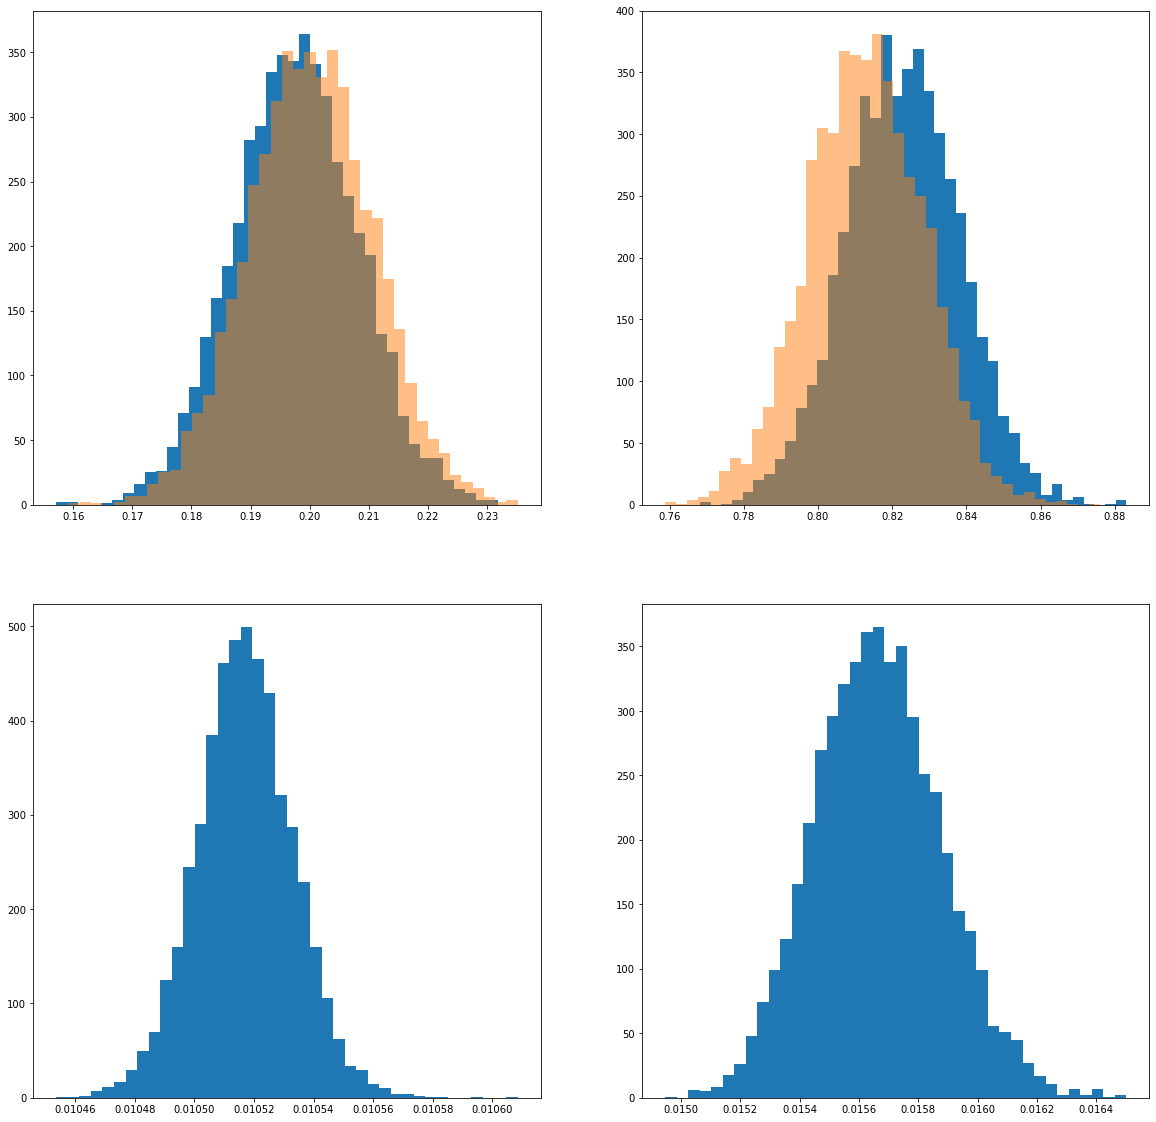

In [58]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [59]:



mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')






 mean:  0.1977, rms  0.0105, mean fit err  0.0105  |  diag. chi2 fit    0.2002, rms  0.0106, mean fit err  0.0060
 sig2:  0.8230, rms  0.0154, mean fit err  0.0157  |  diag. chi2 fit    0.8130, rms  0.0155, mean fit err  0.0081



